# Task 2

## Import Libraries

In [1]:
# import library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange

# sklearn
import sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectKBest, r_regression, f_regression
from sklearn.gaussian_process.kernels import Matern, RBF, CompoundKernel, Product, Sum, ExpSineSquared, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, IsolationForest, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, make_scorer, f1_score, confusion_matrix
from sklearn.decomposition import PCA

# boost algorithm
import xgboost as xgb
import catboost as cat
import lightgbm as lgb

# torch
import torch
from torch import nn
from torch.nn import Module, Linear, Dropout
from torch.nn.functional import tanh, softmax, mse_loss, relu, sigmoid, binary_cross_entropy, nll_loss
from torch.optim import Adam, SGD

# bio library
import biosppy
from biosppy import storage
from biosppy.signals import ecg

# import ResNet
from ResNet import ResNet

DATA_DIR = "Data"
RESULT_DIR = "Result"

## Load Data

### Load Data

In [2]:
# Load Data
X_train_df = pd.read_csv(os.path.join(DATA_DIR, "X_train.csv"), header=0, index_col=0)
X_test_df = pd.read_csv(os.path.join(DATA_DIR, "X_test.csv"), header=0, index_col=0)
y_train_df = pd.read_csv(os.path.join(DATA_DIR, "y_train.csv"), header=0, index_col=0)

X_train = X_train_df.values
X_test = X_test_df.values
y_train = y_train_df.values.ravel()

In [3]:
# 获取有效长度
X_train_len = []
for row in X_train:
    tail_id = np.where(np.isnan(row))[0]
    if tail_id.shape[0] > 0:
        X_train_len.append(tail_id[0])
    else:
        X_train_len.append(X_train.shape[1])

X_test_len = []
for row in X_test:
    tail_id = np.where(np.isnan(row))[0]
    if tail_id.shape[0] > 0:
        X_test_len.append(tail_id[0])
    else:
        X_test_len.append(X_test.shape[1])

X_train_len, X_test_len = np.array(X_train_len), np.array(X_test_len)

## 识别Class 3的数据

In [ ]:
# LSTM
class Class3_Detector(nn.Module):
    def __init__(self) -> None:
        super(Class3_Detector, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, bidirectional=False, batch_first=True) # 设置batch_size在前
        self.linear1 = nn.Linear(in_features=64, out_features=8)
        self.dropout1 = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(in_features=8, out_features=2)
    
    def forward(self, X: torch.Tensor): # 这里的X需要是(batch_size, sequence_len)
        output, (h_n, c_n) = self.lstm1(X)
        output = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)[0] # 解压LSTM输出
        output = output[:, -1, :].reshape((output.shape[0], output.shape[2])) # 取最后一个时间步的output
        # h_n = torch.concat([h_n[0], h_n[1]], dim=1)
        output = sigmoid(self.linear1(output))
        output = self.dropout1(output)
        output = self.linear2(output)
        return output

class Class3_Detection_Model(object):
    def __init__(self) -> None:
        self.model = Class3_Detector()
        self.optimizer = Adam(self.model.parameters(), lr=1e-3)
        # self.device = torch.device("cpu")
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.cpu_device = torch.device("cpu")
        self.model.to(self.device)
    
    def fit(self, X: np.ndarray, y: np.ndarray, X_len: np.ndarray, epochs: int = 100, X_valid: np.ndarray = None, y_valid: np.ndarray = None, X_len_valid: np.ndarray = None) -> None:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        y = torch.from_numpy(y).long().to(self.device)
        X_len = torch.from_numpy(X_len).float().to(self.cpu_device)

        dataset = torch.utils.data.TensorDataset(X, X_len, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

        optimizer = Adam(self.model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()

        self.model.train()
        with trange(epochs, desc="Training") as pbar:
            pbar_dict = {}
            for epoch in pbar:
                for X_batch, X_batch_len, y_batch in dataloader:
                    optimizer.zero_grad()
                    # 处理X_batch
                    X_batch = X_batch.reshape(list(X_batch.shape) + [1]) # 输入需要是(sequence_len, batch_size, 1)
                    X_packed = nn.utils.rnn.pack_padded_sequence(X_batch, X_batch_len, enforce_sorted=False, batch_first=True) # 对不同长度序列进行压缩

                    y_pred = self.model(X_packed)
                    loss = criterion(y_pred, y_batch)
                    loss.backward()
                    
                    pbar_dict["lr"] = round(loss.detach().item(), 3)
                    optimizer.step()

                    if X_valid is not None:
                        y_pred = self.predict(X_valid, X_len_valid)
                        y_pred = torch.argmax(torch.softmax(y_pred, dim=-1), dim=1).to(self.cpu_device).detach().numpy()
                        class3_count = y_pred.sum()
                        pbar_dict["class_3_count"] = class3_count
                        f1 = f1_score(y_pred, y_valid)
                        pbar_dict["valid_f1"] = round(f1, 3)
                        self.model.train() # 切换回训练模式
                    pbar.set_postfix(pbar_dict)
    
    def predict(self, X: torch.Tensor, X_len: torch.Tensor) -> torch.Tensor:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        X_len = torch.from_numpy(X_len).float().to(self.cpu_device)

        dataset = torch.utils.data.TensorDataset(X, X_len)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

        self.model.eval()
        y_preds = []
        for X_batch, X_batch_len in dataloader:
            # 处理X_batch
            X_batch = X_batch.reshape(list(X_batch.shape) + [1]) # 输入需要是(sequence_len, batch_size, 1)
            X_packed = nn.utils.rnn.pack_padded_sequence(X_batch, X_batch_len, enforce_sorted=False, batch_first=True) # 对不同长度序列进行压缩

            y_pred = self.model(X_packed)
            y_preds.append(y_pred.reshape(list(X_batch.shape)[:1] + [2]))
        y_preds = torch.cat(y_preds, dim=0)
        return y_preds

# 采样若干数据训练

# 处理数据
X_temp = X_train[:, :10000] # 只取前10000的数据
X_temp_len = []
for x in X_train_len:
    if x > 10000:
        X_temp_len.append(10000)
    else:
        X_temp_len.append(x)
X_temp_len = np.array(X_temp_len)

# 处理数据y
y_temp = (y_train == 3)

# 采样若干class不为3的数据
class_0_ids = np.where(y_train == 0)[0]
class_1_ids = np.where(y_train == 1)[0]
class_2_ids = np.where(y_train == 2)[0]
class_3_ids = np.where(y_train == 3)[0]
class_0_samples_ids = np.random.choice(class_0_ids, size=500, replace=False)
class_1_samples_ids = np.random.choice(class_1_ids, size=400, replace=False)
class_2_samples_ids = np.random.choice(class_2_ids, size=500, replace=False)
train_ids = np.concatenate([class_0_samples_ids[:300], class_1_samples_ids[:200], class_2_samples_ids[:300], class_3_ids[:100]], axis=0)
valid_ids = np.concatenate([class_0_samples_ids[300:], class_1_samples_ids[200:], class_2_samples_ids[300:], class_3_ids[100:]], axis=0)

X_temp_train = X_temp[train_ids]
X_temp_len_train = X_temp_len[train_ids]
y_temp_train = y_temp[train_ids]

X_temp_valid = X_temp[valid_ids]
X_temp_len_valid = X_temp_len[valid_ids]
y_temp_valid = y_temp[valid_ids]

# 训练模型
class3_detection_model = Class3_Detection_Model()
class3_detection_model.fit(X_temp_train, y_temp_train, X_temp_len_train, epochs=100, X_valid=X_temp_valid, y_valid=y_temp_valid, X_len_valid=X_temp_len_valid)

# 预测数据
y_pred = class3_detection_model.predict(X_temp_valid, X_temp_len_valid)

In [ ]:
# CNN
class Class3_Detector(nn.Module):
    def __init__(self, X_shape: tuple) -> None:
        super(Class3_Detector, self).__init__()
        self.layer0 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=5, kernel_size=5, stride=3, padding=2), 
            nn.BatchNorm1d(num_features=5), 
            nn.MaxPool1d(kernel_size=5, stride=3, padding=2), 
            nn.ReLU()
        )
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=10, kernel_size=5, stride=3, padding=2), 
            nn.BatchNorm1d(num_features=10), 
            nn.MaxPool1d(kernel_size=5, stride=3, padding=2), 
            nn.ReLU()
        )
        flatten_dim = self.layer1(self.layer0(torch.ones([X_shape[0], 1, X_shape[1]]))).flatten(start_dim=1).shape[1]

        self.layer2 = nn.Sequential(
            nn.Linear(flatten_dim, 256), 
            nn.ReLU(), 
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 2), 
        )
    
    def forward(self, X: torch.Tensor): # 这里的X需要是(batch_size, sequence_len)
        output = self.layer0(X)
        output = self.layer1(output)
        output = output.flatten(start_dim=1)
        output = self.layer2(output)
        output = self.layer3(output)
        return output

class Class3_Detection_Model(object):
    def __init__(self, X_shape: tuple) -> None:
        self.model = Class3_Detector(X_shape)
        self.optimizer = Adam(self.model.parameters(), lr=1e-3)
        # self.device = torch.device("cpu")
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.cpu_device = torch.device("cpu")
        self.model.to(self.device)
    
    def fit(self, X: np.ndarray, y: np.ndarray, X_len: np.ndarray, epochs: int = 100, X_valid: np.ndarray = None, y_valid: np.ndarray = None, X_len_valid: np.ndarray = None) -> None:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        y = torch.from_numpy(y).long().to(self.device)
        X_len = torch.from_numpy(X_len).float().to(self.cpu_device)

        dataset = torch.utils.data.TensorDataset(X, X_len, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

        optimizer = Adam(self.model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        self.model.train()
        with trange(epochs, desc="Training") as pbar:
            pbar_dict = {}
            for epoch in pbar:
                for X_batch, X_batch_len, y_batch in dataloader:
                    optimizer.zero_grad()
                    # 处理X_batch
                    X_batch = X_batch.reshape([X_batch.shape[0], 1, X_batch.shape[1]]) # 输入需要是(sequence_len, 1, batch_size)

                    y_pred = self.model(X_batch)
                    loss = criterion(y_pred, y_batch)
                    loss.backward()
                    
                    pbar_dict["lr"] = round(loss.detach().item(), 3)
                    optimizer.step()

                    if X_valid is not None:
                        y_pred = self.predict(X_valid, X_len_valid)
                        y_pred = torch.argmax(torch.softmax(y_pred, dim=-1), dim=1).to(self.cpu_device).detach().numpy()
                        class3_count = y_pred.sum()
                        pbar_dict["class_3_count"] = class3_count
                        f1 = f1_score(y_pred, y_valid)
                        pbar_dict["valid_f1"] = round(f1, 3)
                        self.model.train() # 切换回训练模式
                    pbar.set_postfix(pbar_dict)
    
    def predict(self, X: torch.Tensor, X_len: torch.Tensor) -> torch.Tensor:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        X_len = torch.from_numpy(X_len).float().to(self.cpu_device)

        dataset = torch.utils.data.TensorDataset(X, X_len)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

        self.model.eval()
        y_preds = []
        for X_batch, X_batch_len in dataloader:
            # 处理X_batch
            X_batch = X_batch.reshape([X_batch.shape[0], 1, X_batch.shape[1]]) # 输入需要是(sequence_len, 1, batch_size)

            y_pred = self.model(X_batch)
            y_preds.append(y_pred.reshape(list(X_batch.shape)[:1] + [2]))
        y_preds = torch.cat(y_preds, dim=0)
        return y_preds

# 采样若干数据训练

# 处理数据
X_temps = []
for x in X_train:
    nan_ids = np.where(np.isnan(x))[0]
    x[nan_ids] = 0 # 将nan填充为0
    x = x[:10000]
    X_temps.append(x)
X_temp = np.array(X_temps)

X_test_temps = []
for x in X_test:
    nan_ids = np.where(np.isnan(x))[0]
    x[nan_ids] = 0 # 将nan填充为0
    x = x[:10000]
    X_test_temps.append(x)
X_test_temps = np.array(X_test_temps)

X_temp_len = []
for x in X_train_len:
    if x > 10000:
        X_temp_len.append(10000)
    else:
        X_temp_len.append(x)
X_temp_len = np.array(X_temp_len)

X_test_temp_len = []
for x in X_test_len:
    if x > 10000:
        X_test_temp_len.append(10000)
    else:
        X_test_temp_len.append(x)
X_test_temp_len = np.array(X_test_temp_len)

# 处理数据y
y_temp = (y_train == 3)

# 采样若干class不为3的数据
class_0_ids = np.where(y_train == 0)[0]
class_1_ids = np.where(y_train == 1)[0]
class_2_ids = np.where(y_train == 2)[0]
class_3_ids = np.where(y_train == 3)[0]
class_0_samples_ids = np.random.choice(class_0_ids, size=500, replace=False)
class_1_samples_ids = np.random.choice(class_1_ids, size=400, replace=False)
class_2_samples_ids = np.random.choice(class_2_ids, size=500, replace=False)
train_ids = np.concatenate([class_0_samples_ids[:300], class_1_samples_ids[:200], class_2_samples_ids[:300], class_3_ids[:100]], axis=0)
valid_ids = np.concatenate([class_0_samples_ids[300:], class_1_samples_ids[200:], class_2_samples_ids[300:], class_3_ids[100:]], axis=0)

X_temp_train = X_temp[train_ids]
X_temp_len_train = X_temp_len[train_ids]
y_temp_train = y_temp[train_ids]

X_temp_valid = X_temp[valid_ids]
X_temp_len_valid = X_temp_len[valid_ids]
y_temp_valid = y_temp[valid_ids]

# 训练模型
class3_detection_model = Class3_Detection_Model(X_temp_train.shape)
class3_detection_model.fit(X_temp_train, y_temp_train, X_temp_len_train, epochs=200, X_valid=X_temp_valid, y_valid=y_temp_valid, X_len_valid=X_temp_len_valid)

# 预测数据
test_y_pred = class3_detection_model.predict(X_test_temps, X_test_temp_len)
test_y_pred = torch.argmax(torch.softmax(test_y_pred, dim=-1), dim=1).to("cpu").detach().numpy()

y_pred = class3_detection_model.predict(X_temp, X_temp_len)
y_pred_arg = torch.argmax(torch.softmax(y_pred, dim=-1), dim=1).to("cpu").detach().numpy()
f1_score(y_pred_arg, y_temp)

Training: 100%|██████████| 200/200 [00:26<00:00,  7.55it/s, lr=0, class_3_count=41, valid_f1=0.396]     


In [ ]:
# 用全部数据训练

# 处理数据
X_temp = X_train[:, :10000]
X_temp_len = []
for x in X_train_len:
    if x > 10000:
        X_temp_len.append(10000)
    else:
        X_temp_len.append(x)
X_temp_len = np.array(X_temp_len)

# 处理数据y
y_temp = (y_train == 3)

# 训练模型
class3_detection_model = Class3_Detection_Model()
class3_detection_model.fit(X_temp, y_temp, X_temp_len, epochs=1)

# 预测数据
y_pred = class3_detection_model.predict(X_temp, X_temp_len)

Training: 100%|██████████| 1/1 [00:22<00:00, 22.23s/it, lr=0.934]


## Preprocess Data

需要确保X_train和X_train_len以及X_test和X_test_len是训练集和测试集的有效数据

这部分数据会直接经过Biosppy的ecg函数进行特征抽取

In [4]:
# get ecg info (比较松)
def check_template_result(templates: np.ndarray) -> list:
    # 检查有没有一个template里有多个心跳的情况
    check_result = True
    error_num = 0
    error_ids = []
    for template_i, template in enumerate(templates):
        peak_threshold = np.max(template) * 0.7
        peak_region = np.array(np.where(template > peak_threshold))
        if np.max(peak_region) - np.min(peak_region) > 0.5 * template.shape[0]:
            error_num += 1
            error_ids.append(template_i)
    return error_ids

def get_ecg_info(X, X_len):
    ts_lst = []
    filtered_lst = []
    rpeaks_lst = []
    templates_ts_lst = []
    templates_lst = []
    heart_rate_ts_lst = []
    heart_rate_lst = []

    error_ids = []
    part_error_lst = []
    for i, (signal, sig_len) in enumerate(zip(X, X_len)):
        ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(signal[:sig_len], sampling_rate=300., show=False)
        # check template
        # if check_ecg_result(templates) == False:
        #     error_ids.append(i)
        #     error_templates.append(templates)
        #     continue

        # template_error_ids = check_template_result(templates) # 以较轻松的方式处理ecg处理异常
        template_error_ids = [] # 以较轻松的方式处理ecg处理异常

        # delete error data
        rpeaks = np.delete(rpeaks, template_error_ids, axis=0)
        templates_ts = np.delete(templates_ts, template_error_ids, axis=0)
        templates = np.delete(templates, template_error_ids, axis=0)
        if len(templates) < 1:
            error_ids.append(i)
            continue

        if len(template_error_ids) > 0:
            part_error_lst.append(len(ts_lst))

        ts_lst.append(ts) # Signal time axis reference (seconds)
        filtered_lst.append(filtered) # Filtered ECG signal
        rpeaks_lst.append(rpeaks) # R-peak location indices
        templates_ts_lst.append(templates_ts) # Templates time axis reference
        templates_lst.append(templates) # Extracted heartbeat templates
        heart_rate_ts_lst.append(heart_rate_ts) # Heart rate time axis reference (seconds)
        heart_rate_lst.append(heart_rate) # Instantaneous heart rate (bpm)
    return ts_lst, filtered_lst, rpeaks_lst, templates_ts_lst, templates_lst, heart_rate_ts_lst, heart_rate_lst

ts_lst, filtered_lst, rpeaks_lst, templates_ts_lst, templates_lst, heart_rate_ts_lst, heart_rate_lst = get_ecg_info(X_train, X_train_len)
ts_lst_test, filtered_lst_test, rpeaks_lst_test, templates_ts_lst_test, templates_lst_test, heart_rate_ts_lst_test, heart_rate_lst_test = get_ecg_info(X_test, X_test_len)

In [5]:
# 统计y_train的值
class_0_num = np.sum(y_train == 0)
class_1_num = np.sum(y_train == 1)
class_2_num = np.sum(y_train == 2)
class_3_num = np.sum(y_train == 3)
print("class 0 count: {}".format(class_0_num))
print("class 1 count: {}".format(class_1_num))
print("class 2 count: {}".format(class_2_num))
print("class 3 count: {}".format(class_3_num))

class 0 count: 3030
class 1 count: 443
class 2 count: 1474
class 3 count: 170


In [5]:
# get average template
max_height = None
for templates in templates_lst:
    for template in templates:
        if max_height is None or np.max(template) > max_height:
            max_height = np.max(template)

# scaler现在只是简单的缩放，不确定绝对高度有没有用
def scaler(template: np.array):
    result = template / max_height
    return result

# 对所有的templates进行缩放
templates_lst = [scaler(templates) for templates in templates_lst]

def get_average_templates(templates):
    templates = scaler(templates)
    avg_templates = templates.sum(axis=0) / templates.shape[0]
    return avg_templates

avg_templates_lst = [get_average_templates(templates) for templates in templates_lst]

157

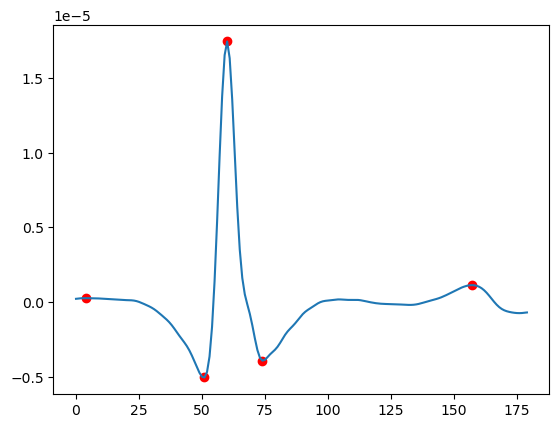

In [6]:
# 测试获取RQPST
templates = avg_templates_lst[10]

def get_PQRST_from_template(template: np.array):
    error_state = False

    # get R
    R_id = np.where(template == np.max(template))[0][0]
    R = template[R_id]

    # get Q
    if R_id == 0:
        Q_id = R_id
        error_state = True
    else:
        Q_id = np.where(template[:R_id] == np.min(template[:R_id]))[0][0]
    Q = template[Q_id]

    # get P
    if Q_id == 0:
        P_id = 0
        error_state = True
    else:
        P_id = np.where(template[:Q_id] == np.max(template[:Q_id]))[0][0]
    P = template[P_id]

    # get S
    if R_id == 179:
        S_id = R_id
        error_state = True
    else:
        S_id = np.where(template[R_id + 1:] == np.min(template[R_id + 1:]))[0][0] + R_id + 1
    S = template[S_id]

    # get T
    if S_id == 179:
        T_id = 179
        error_state = True
    else:
        T_id = np.where(template[S_id + 1:] == np.max(template[S_id + 1:]))[0][0] + S_id + 1
    T = template[T_id]

    # assert (P_id < Q_id and Q_id < R_id and R_id < S_id and S_id < T_id)

    # cal interval
    QRS = S_id - Q_id
    PR = R_id - P_id
    PQ = R_id - Q_id
    ST = T_id - S_id
    QT = T_id - Q_id
    return (P, Q, R, S, T), (P_id, Q_id, R_id, S_id, T_id), (QRS, PR, PQ, ST, QT), error_state

(P, Q, R, S, T), (P_id, Q_id, R_id, S_id, T_id), (QRS, PR, PQ, ST, QT), _ = get_PQRST_from_template(templates)

plt.plot(np.arange(0, templates.shape[0], 1), templates)
plt.scatter([P_id, Q_id, R_id, S_id, T_id], [P, Q, R, S, T], c="r")
T_id

In [7]:
# get P Q R S T
def get_PQRST(templates_lst):
    PQRST = []
    for templates_i, templates in enumerate(templates_lst):
        template_PQRST = {
            "P": [], 
            "Q": [], 
            "R": [], 
            "S": [], 
            "T": [], 
            "P_id": [], 
            "Q_id": [], 
            "R_id": [], 
            "S_id": [], 
            "T_id": [], 
            "QRS": [], 
            "PR": [], 
            "PQ": [], 
            "ST": [], 
            "QT": [], 
            "error_state": []
        }
        for template_i, template in enumerate(templates):
            (P, Q, R, S, T), (P_id, Q_id, R_id, S_id, T_id), (QRS, PR, PQ, ST, QT), error_state = get_PQRST_from_template(template)
            template_PQRST["P"].append(P)
            template_PQRST["Q"].append(Q)
            template_PQRST["R"].append(R)
            template_PQRST["S"].append(S)
            template_PQRST["T"].append(T)
            template_PQRST["P_id"].append(P_id)
            template_PQRST["Q_id"].append(Q_id)
            template_PQRST["R_id"].append(R_id)
            template_PQRST["S_id"].append(S_id)
            template_PQRST["T_id"].append(T_id)
            template_PQRST["QRS"].append(QRS)
            template_PQRST["PR"].append(PR)
            template_PQRST["PQ"].append(PQ)
            template_PQRST["ST"].append(ST)
            template_PQRST["QT"].append(QT)
            template_PQRST["error_state"].append(error_state)
        PQRST.append(template_PQRST)
    return PQRST
PQRST = get_PQRST(templates_lst)
PQRST_test = get_PQRST(templates_lst_test)

In [8]:
# 处理rpeak
rpeaks_new = []
for rpeaks in rpeaks_lst:
    rpeaks_iterval = []
    for i in range(1, rpeaks.shape[0]):
        rpeaks_iterval.append(rpeaks[i] - rpeaks[i - 1])
    rpeaks_iterval = np.array(rpeaks_iterval)
    rpeaks_new.append(rpeaks_iterval)

rpeaks_new_test = []
for rpeaks in rpeaks_lst_test:
    rpeaks_iterval = []
    for i in range(1, rpeaks.shape[0]):
        rpeaks_iterval.append(rpeaks[i] - rpeaks[i - 1])
    rpeaks_iterval = np.array(rpeaks_iterval)
    rpeaks_new_test.append(rpeaks_iterval)

# 处理heart_rate
heart_rate_new = []
for heart_rate in heart_rate_lst:
    if heart_rate.shape[0] == 0:
        heart_rate = np.array(-100)
    heart_rate_new.append(heart_rate)

heart_rate_new_test = []
for heart_rate in heart_rate_lst_test:
    if heart_rate.shape[0] == 0:
        heart_rate = np.array(-100)
    heart_rate_new_test.append(heart_rate)

In [9]:
def get_PQRST_scope_stats(templates_lst: [np.ndarray], start_ids: [np.ndarray], end_ids: [np.ndarray]) -> np.ndarray:
    scope_mean = []
    scope_std = []
    scope_max = []
    scope_min = []
    for templates, start_id, end_id in zip(templates_lst, start_ids, end_ids):
        templates = templates / np.max(templates) # 归一化
        templates_mean = []
        templates_std = []
        templates_max = []
        templates_min = []
        for template, s_i, e_i in zip(templates, start_id, end_id):
            template = template[s_i: e_i + 1]
            templates_mean.append(np.mean(template))
            templates_std.append(np.std(template))
            templates_max.append(np.max(template))
            templates_min.append(np.min(template))
        scope_mean.append(np.mean(templates_mean))
        scope_std.append(np.mean(templates_std))
        scope_max.append(np.mean(templates_max))
        scope_min.append(np.mean(templates_min))
    scope_mean = np.array(scope_mean)
    scope_std = np.array(scope_std)
    scope_max = np.array(scope_max)
    scope_min = np.array(scope_min)
    return scope_mean, scope_std, scope_max, scope_min

def get_PQRST_range_stats(start_ids: [np.ndarray], end_ids: [np.ndarray]) -> np.ndarray:
    range_mean = []
    range_std = []
    range_max = []
    range_min = []
    for start_id, end_id in zip(start_ids, end_ids):
        diff_id = np.array(end_id) - np.array(start_id)
        templates_mean = np.mean(diff_id)
        templates_std = np.std(diff_id)
        templates_max = np.max(diff_id)
        templates_min = np.min(diff_id)
        range_mean.append(np.mean(templates_mean))
        range_std.append(np.mean(templates_std))
        range_max.append(np.mean(templates_max))
        range_min.append(np.mean(templates_min))
    range_mean = np.array(range_mean)
    range_std = np.array(range_std)
    range_max = np.array(range_max)
    range_min = np.array(range_min)
    return range_mean, range_std, range_max, range_min

def get_PQRST_slope_stats(templates_lst: [np.ndarray], start_ids: [np.ndarray], end_ids: [np.ndarray]) -> np.ndarray:
    slope_mean = []
    slope_std = []
    slope_max = []
    slope_min = []
    for templates, start_id, end_id in zip(templates_lst, start_ids, end_ids):
        templates = templates / np.max(templates) # 归一化
        slopes = []
        for template, s_i, e_i in zip(templates, start_id, end_id):
            if s_i == e_i:
                slope = 0
            else:
                slope = (template[e_i] - template[s_i]) / (e_i - s_i)
            slopes.append(slope)
        slope_mean.append(np.mean(slopes))
        slope_std.append(np.std(slopes))
        slope_max.append(np.max(slopes))
        slope_min.append(np.min(slopes))
    slope_mean = np.array(slope_mean)
    slope_std = np.array(slope_std)
    slope_max = np.array(slope_max)
    slope_min = np.array(slope_min)
    return slope_mean, slope_std, slope_max, slope_min

In [10]:
# 统计各种指标
def get_valid_features(rpeaks, heart_rate, PQRST, rpeaks_ids, filtered_ecg, templates_lst):
    # rpeak
    rpeak_mean = np.array([np.average(x) for x in rpeaks])
    rpeak_median = np.array([np.median(x) for x in rpeaks])
    rpeak_std = np.array([np.std(x) for x in rpeaks])
    rpeak_min = np.array([np.min(x) for x in rpeaks])
    rpeak_max = np.array([np.max(x) for x in rpeaks])

    # heart rate
    hr_mean = np.array([np.average(x) for x in heart_rate])
    hr_median = np.array([np.median(x) for x in heart_rate])
    hr_std = np.array([np.std(x) for x in heart_rate])
    hr_min = np.array([np.min(x) for x in heart_rate])
    hr_max = np.array([np.max(x) for x in heart_rate])

    # PQRST
    # P
    P_mean = np.array([np.mean(x["P"]) for x in PQRST])
    P_median = np.array([np.median(x["P"]) for x in PQRST])
    P_std = np.array([np.std(x["P"]) for x in PQRST])
    P_min = np.array([np.min(x["P"]) for x in PQRST])
    P_max = np.array([np.max(x["P"]) for x in PQRST])

    # Q
    Q_mean = np.array([np.mean(x["Q"]) for x in PQRST])
    Q_median = np.array([np.median(x["Q"]) for x in PQRST])
    Q_std = np.array([np.std(x["Q"]) for x in PQRST])
    Q_min = np.array([np.min(x["Q"]) for x in PQRST])
    Q_max = np.array([np.max(x["Q"]) for x in PQRST])

    # R
    R_mean = np.array([np.mean(x["R"]) for x in PQRST])
    R_median = np.array([np.median(x["R"]) for x in PQRST])
    R_std = np.array([np.std(x["R"]) for x in PQRST])
    R_min = np.array([np.min(x["R"]) for x in PQRST])
    R_max = np.array([np.max(x["R"]) for x in PQRST])

    # S
    S_mean = np.array([np.mean(x["S"]) for x in PQRST])
    S_median = np.array([np.median(x["S"]) for x in PQRST])
    S_std = np.array([np.std(x["S"]) for x in PQRST])
    S_min = np.array([np.min(x["S"]) for x in PQRST])
    S_max = np.array([np.max(x["S"]) for x in PQRST])

    # T
    T_mean = np.array([np.mean(x["T"]) for x in PQRST])
    T_median = np.array([np.median(x["T"]) for x in PQRST])
    T_std = np.array([np.std(x["T"]) for x in PQRST])
    T_min = np.array([np.min(x["T"]) for x in PQRST])
    T_max = np.array([np.max(x["T"]) for x in PQRST])

    # P_i
    P_id_mean = np.array([np.mean(x["P_id"]) for x in PQRST])
    P_id_median = np.array([np.median(x["P_id"]) for x in PQRST])
    P_id_std = np.array([np.std(x["P_id"]) for x in PQRST])
    P_id_min = np.array([np.min(x["P_id"]) for x in PQRST])
    P_id_max = np.array([np.max(x["P_id"]) for x in PQRST])

    # Q_i
    Q_id_mean = np.array([np.mean(x["Q_id"]) for x in PQRST])
    Q_id_median = np.array([np.median(x["Q_id"]) for x in PQRST])
    Q_id_std = np.array([np.std(x["Q_id"]) for x in PQRST])
    Q_id_min = np.array([np.min(x["Q_id"]) for x in PQRST])
    Q_id_max = np.array([np.max(x["Q_id"]) for x in PQRST])

    # R_i
    R_id_mean = np.array([np.mean(x["R_id"]) for x in PQRST])
    R_id_median = np.array([np.median(x["R_id"]) for x in PQRST])
    R_id_std = np.array([np.std(x["R_id"]) for x in PQRST])
    R_id_min = np.array([np.min(x["R_id"]) for x in PQRST])
    R_id_max = np.array([np.max(x["R_id"]) for x in PQRST])

    # S_i
    S_id_mean = np.array([np.mean(x["S_id"]) for x in PQRST])
    S_id_median = np.array([np.median(x["S_id"]) for x in PQRST])
    S_id_std = np.array([np.std(x["S_id"]) for x in PQRST])
    S_id_min = np.array([np.min(x["S_id"]) for x in PQRST])
    S_id_max = np.array([np.max(x["S_id"]) for x in PQRST])

    # T_i
    T_id_mean = np.array([np.mean(x["T_id"]) for x in PQRST])
    T_id_median = np.array([np.median(x["T_id"]) for x in PQRST])
    T_id_std = np.array([np.std(x["T_id"]) for x in PQRST])
    T_id_min = np.array([np.min(x["T_id"]) for x in PQRST])
    T_id_max = np.array([np.max(x["T_id"]) for x in PQRST])

    # QRS
    QRS_mean = np.array([np.mean(x["QRS"]) for x in PQRST])
    QRS_median = np.array([np.median(x["QRS"]) for x in PQRST])
    QRS_std = np.array([np.std(x["QRS"]) for x in PQRST])
    QRS_min = np.array([np.min(x["QRS"]) for x in PQRST])
    QRS_max = np.array([np.max(x["QRS"]) for x in PQRST])

    # PR
    PR_mean = np.array([np.mean(x["PR"]) for x in PQRST])
    PR_median = np.array([np.median(x["PR"]) for x in PQRST])
    PR_std = np.array([np.std(x["PR"]) for x in PQRST])
    PR_min = np.array([np.min(x["PR"]) for x in PQRST])
    PR_max = np.array([np.max(x["PR"]) for x in PQRST])

    # PQ
    PQ_mean = np.array([np.mean(x["PQ"]) for x in PQRST])
    PQ_median = np.array([np.median(x["PQ"]) for x in PQRST])
    PQ_std = np.array([np.std(x["PQ"]) for x in PQRST])
    PQ_min = np.array([np.min(x["PQ"]) for x in PQRST])
    PQ_max = np.array([np.max(x["PQ"]) for x in PQRST])

    # ST
    ST_mean = np.array([np.mean(x["ST"]) for x in PQRST])
    ST_median = np.array([np.median(x["ST"]) for x in PQRST])
    ST_std = np.array([np.std(x["ST"]) for x in PQRST])
    ST_min = np.array([np.min(x["ST"]) for x in PQRST])
    ST_max = np.array([np.max(x["ST"]) for x in PQRST])

    # QT
    QT_mean = np.array([np.mean(x["QT"]) for x in PQRST])
    QT_median = np.array([np.median(x["QT"]) for x in PQRST])
    QT_std = np.array([np.std(x["QT"]) for x in PQRST])
    QT_min = np.array([np.min(x["QT"]) for x in PQRST])
    QT_max = np.array([np.max(x["QT"]) for x in PQRST])

    # RS斜率
    RS_slope_mean, RS_slope_std, RS_slope_max, RS_slope_min = get_PQRST_slope_stats(templates_lst, [sample["R_id"] for sample in PQRST], [sample["S_id"] for sample in PQRST])
    ST_slope_mean, ST_slope_std, ST_slope_max, ST_slope_min = get_PQRST_slope_stats(templates_lst, [sample["S_id"] for sample in PQRST], [sample["T_id"] for sample in PQRST])

    # QRS幅度
    QRS_scope_mean, QRS_scope_std, QRS_scope_max, QRS_scope_min = get_PQRST_scope_stats(templates_lst, [sample["Q_id"] for sample in PQRST], [sample["S_id"] for sample in PQRST])

    # PR幅度
    PR_scope_mean, PR_scope_std, PR_scope_max, PR_scope_min = get_PQRST_scope_stats(templates_lst, [sample["P_id"] for sample in PQRST], [sample["R_id"] for sample in PQRST])

    # QT幅度
    QT_scope_mean, QT_scope_std, QT_scope_max, QT_scope_min = get_PQRST_scope_stats(templates_lst, [sample["Q_id"] for sample in PQRST], [sample["T_id"] for sample in PQRST])

    # QR幅度
    QR_scope_mean, QR_scope_std, QR_scope_max, QR_scope_min = get_PQRST_scope_stats(templates_lst, [sample["Q_id"] for sample in PQRST], [sample["R_id"] for sample in PQRST])
    QR_range_mean, QR_range_std, QR_range_max, QR_range_min = get_PQRST_range_stats([sample["Q_id"] for sample in PQRST], [sample["R_id"] for sample in PQRST])

    # RS幅度
    RS_scope_mean, RS_scope_std, RS_scope_max, RS_scope_min = get_PQRST_scope_stats(templates_lst, [sample["R_id"] for sample in PQRST], [sample["S_id"] for sample in PQRST])
    RS_range_mean, RS_range_std, RS_range_max, RS_range_min = get_PQRST_range_stats([sample["R_id"] for sample in PQRST], [sample["S_id"] for sample in PQRST])

    # ST幅度
    ST_scope_mean, ST_scope_std, ST_scope_max, ST_scope_min = get_PQRST_scope_stats(templates_lst, [sample["S_id"] for sample in PQRST], [sample["T_id"] for sample in PQRST])

    # PQ幅度
    PQ_scope_mean, PQ_scope_std, PQ_scope_max, PQ_scope_min = get_PQRST_scope_stats(templates_lst, [sample["P_id"] for sample in PQRST], [sample["Q_id"] for sample in PQRST])

    # QS幅度
    QS_scope_mean, QS_scope_std, QS_scope_max, QS_scope_min = get_PQRST_scope_stats(templates_lst, [sample["Q_id"] for sample in PQRST], [sample["S_id"] for sample in PQRST])
    QS_range_mean, QS_range_std, QS_range_max, QS_range_min = get_PQRST_range_stats([sample["Q_id"] for sample in PQRST], [sample["S_id"] for sample in PQRST])

    # RT幅度
    RT_scope_mean, RT_scope_std, RT_scope_max, RT_scope_min = get_PQRST_scope_stats(templates_lst, [sample["R_id"] for sample in PQRST], [sample["T_id"] for sample in PQRST])
    RT_range_mean, RT_range_std, RT_range_max, RT_range_min = get_PQRST_range_stats([sample["R_id"] for sample in PQRST], [sample["T_id"] for sample in PQRST])

    # ST幅度
    ST_scope_mean, ST_scope_std, ST_scope_max, ST_scope_min = get_PQRST_scope_stats(templates_lst, [sample["S_id"] for sample in PQRST], [sample["T_id"] for sample in PQRST])
    ST_range_mean, ST_range_std, ST_range_max, ST_range_min = get_PQRST_range_stats([sample["S_id"] for sample in PQRST], [sample["T_id"] for sample in PQRST])

    # error_state
    error_count = np.array([np.sum(x["error_state"]) for x in PQRST])
    error_mean = np.array([np.mean(x["error_state"]) for x in PQRST])

    # 计算前2000的peak数量
    peak_counts = np.array([(rpeak <= 2000).sum() for rpeak in rpeaks_ids])

    # 计算peak的mean和std(相对，除以该ecg的最大值)
    ecg_peak_mean = np.array([np.mean(filtered_array[rpeaks_id] / np.max(filtered_array)) for rpeaks_id, filtered_array in zip(rpeaks_ids, filtered_ecg)])
    ecg_peak_std = np.array([np.std(filtered_array[rpeaks_id] / np.max(filtered_array)) for rpeaks_id, filtered_array in zip(rpeaks_ids, filtered_ecg)])
    
    # 计算ecg的绝对最大值
    ecg_max = np.array([np.max(filtered_array) for filtered_array in filtered_ecg])
    ecg_min = np.array([np.min(filtered_array) for filtered_array in filtered_ecg])
    ecg_mean = np.array([np.mean(filtered_array) for filtered_array in filtered_ecg])
    ecg_std = np.array([np.std(filtered_array) for filtered_array in filtered_ecg])
    ecg_median = np.array([np.median(filtered_array) for filtered_array in filtered_ecg])

    # 计算ecg的绝对最大最小值之比
    ecg_max_min_ratio = np.abs(ecg_max / ecg_min)

    # 计算锯齿数量
    saw_counts = []
    for filtered_array in filtered_ecg:
        saw_count = 0
        for y_1, y_2, y_3 in zip(filtered_array[:-2], filtered_array[1: -1], filtered_array[2:]):
            if (y_1 >= y_2) != (y_2 >= y_3):
                saw_count += 1
        saw_counts.append(saw_count)
    saw_counts = np.array(saw_counts)

    # 截取前2000的数据中穿过0.5 Max直线的点的个数
    upper_quant_counts = []
    half_counts = []
    lower_quant_counts = []
    zero_quant_counts = []
    neg_lower_quant_counts = []
    neg_half_counts = []
    neg_higher_quant_counts = []
    percent_1_counts = []
    percent_10_counts = []
    percent_90_counts = []
    percent_95_counts = []
    percent_99_counts = []
    neg_percent_1_counts = []
    neg_percent_10_counts = []
    neg_percent_90_counts = []
    neg_percent_95_counts = []
    neg_percent_99_counts = []
    percent_1_99_ranges = []
    percent_5_95_ranges = []
    percent_10_90_ranges = []
    percent_25_75_ranges = []
    neg_percent_1_99_ranges = []
    neg_percent_5_95_ranges = []
    neg_percent_10_90_ranges = []
    neg_percent_25_75_ranges = []
    for filtered_array in filtered_ecg:
        ecg_array_max = np.max(filtered_array)
        ecg_array_min = np.min(filtered_array)
        filtered_array = filtered_array[:2000]
        upper_quant_count = 0
        half_count = 0
        lower_quant_count = 0
        zero_quant_count = 0
        neg_lower_quant_count = 0
        neg_half_count = 0
        neg_higher_quant_count = 0
        percent_1_count = 0
        percent_10_count = 0
        percent_90_count = 0
        percent_95_count = 0
        percent_99_count = 0
        neg_percent_1_count = 0
        neg_percent_10_count = 0
        neg_percent_90_count = 0
        neg_percent_95_count = 0
        neg_percent_99_count = 0
        for y_1, y_2 in zip(filtered_array[:-1], filtered_array[1:]):
            if (y_1 >= 0.5 * ecg_array_max) != (y_2 >= 0.5 * ecg_array_max):
                half_count += 1
            if (y_1 >= 0.75 * ecg_array_max) != (y_2 >= 0.75 * ecg_array_max):
                upper_quant_count += 1
            if (y_1 >= 0.25 * ecg_array_max) != (y_2 >= 0.25 * ecg_array_max):
                lower_quant_count += 1
            if (y_1 >= 0) + (y_2 >= 0) == 1:
                zero_quant_count += 1
            if (y_1 >= 0.25 * ecg_array_min) != (y_2 >= 0.25 * ecg_array_min):
                neg_lower_quant_count += 1
            if (y_1 >= 0.5 * ecg_array_min) != (y_2 >= 0.5 * ecg_array_min):
                neg_half_count += 1
            if (y_1 >= 0.75 * ecg_array_min) != (y_2 >= 0.75 * ecg_array_min):
                neg_higher_quant_count += 1
            if (y_1 >= 0.01 * ecg_array_max) != (y_2 >= 0.01 * ecg_array_max):
                percent_1_count += 1
            if (y_1 >= 0.10 * ecg_array_max) != (y_2 >= 0.10 * ecg_array_max):
                percent_10_count += 1
            if (y_1 >= 0.90 * ecg_array_max) != (y_2 >= 0.90 * ecg_array_max):
                percent_90_count += 1
            if (y_1 >= 0.95 * ecg_array_max) != (y_2 >= 0.95 * ecg_array_max):
                percent_95_count += 1
            if (y_1 >= 0.99 * ecg_array_max) != (y_2 >= 0.99 * ecg_array_max):
                percent_99_count += 1
            if (y_1 >= 0.01 * ecg_array_min) != (y_2 >= 0.01 * ecg_array_min):
                neg_percent_1_count += 1
            if (y_1 >= 0.10 * ecg_array_min) != (y_2 >= 0.10 * ecg_array_min):
                neg_percent_10_count += 1
            if (y_1 >= 0.90 * ecg_array_min) != (y_2 >= 0.90 * ecg_array_min):
                neg_percent_90_count += 1
            if (y_1 >= 0.95 * ecg_array_min) != (y_2 >= 0.95 * ecg_array_min):
                neg_percent_95_count += 1
            if (y_1 >= 0.99 * ecg_array_min) != (y_2 >= 0.99 * ecg_array_min):
                neg_percent_99_count += 1
        # 计算区间
        percent_1_99_range = ((filtered_array >= 0.01 * ecg_array_max) & (filtered_array <= 0.99 * ecg_array_max)).sum()
        percent_5_95_range = ((filtered_array >= 0.05 * ecg_array_max) & (filtered_array <= 0.95 * ecg_array_max)).sum()
        percent_10_90_range = ((filtered_array >= 0.1 * ecg_array_max) & (filtered_array <= 0.9 * ecg_array_max)).sum()
        percent_25_75_range = ((filtered_array >= 0.25 * ecg_array_max) & (filtered_array <= 0.75 * ecg_array_max)).sum()
        neg_percent_1_99_range = ((filtered_array <= 0.01 * ecg_array_min) & (filtered_array >= 0.99 * ecg_array_min)).sum()
        neg_percent_5_95_range = ((filtered_array <= 0.05 * ecg_array_min) & (filtered_array >= 0.95 * ecg_array_min)).sum()
        neg_percent_10_90_range = ((filtered_array <= 0.1 * ecg_array_min) & (filtered_array >= 0.9 * ecg_array_min)).sum()
        neg_percent_25_75_range = ((filtered_array <= 0.25 * ecg_array_min) & (filtered_array >= 0.75 * ecg_array_min)).sum()

        upper_quant_counts.append(upper_quant_count)
        half_counts.append(half_count)
        lower_quant_counts.append(lower_quant_count)
        zero_quant_counts.append(zero_quant_count)
        neg_lower_quant_counts.append(neg_lower_quant_count)
        neg_half_counts.append(neg_half_count)
        neg_higher_quant_counts.append(neg_higher_quant_count)
        percent_1_counts.append(percent_1_count)
        percent_10_counts.append(percent_10_count)
        percent_90_counts.append(percent_90_count)
        percent_95_counts.append(percent_95_count)
        percent_99_counts.append(percent_99_count)
        neg_percent_1_counts.append(neg_percent_1_count)
        neg_percent_10_counts.append(neg_percent_10_count)
        neg_percent_90_counts.append(neg_percent_90_count)
        neg_percent_95_counts.append(neg_percent_95_count)
        neg_percent_99_counts.append(neg_percent_99_count)
        percent_1_99_ranges.append(percent_1_99_range)
        percent_5_95_ranges.append(percent_5_95_range)
        percent_10_90_ranges.append(percent_10_90_range)
        percent_25_75_ranges.append(percent_25_75_range)
        neg_percent_1_99_ranges.append(neg_percent_1_99_range)
        neg_percent_5_95_ranges.append(neg_percent_5_95_range)
        neg_percent_10_90_ranges.append(neg_percent_10_90_range)
        neg_percent_25_75_ranges.append(neg_percent_25_75_range)
    upper_quant_counts = np.array(upper_quant_counts)
    half_counts = np.array(half_counts)
    lower_quant_counts = np.array(lower_quant_counts)
    zero_quant_counts = np.array(zero_quant_counts)
    neg_lower_quant_counts = np.array(neg_lower_quant_counts)
    neg_half_counts = np.array(neg_half_counts)
    neg_higher_quant_counts = np.array(neg_higher_quant_counts)
    percent_1_counts = np.array(percent_1_counts)
    percent_10_counts = np.array(percent_10_counts)
    percent_90_counts = np.array(percent_90_counts)
    percent_95_counts = np.array(percent_95_counts)
    percent_99_counts = np.array(percent_99_counts)
    neg_percent_1_counts = np.array(neg_percent_1_counts)
    neg_percent_10_counts = np.array(neg_percent_10_counts)
    neg_percent_90_counts = np.array(neg_percent_90_counts)
    neg_percent_95_counts = np.array(neg_percent_95_counts)
    neg_percent_99_counts = np.array(neg_percent_99_counts)
    percent_1_99_ranges = np.array(percent_1_99_ranges)
    percent_5_95_ranges = np.array(percent_5_95_ranges)
    percent_10_90_ranges = np.array(percent_10_90_ranges)
    percent_25_75_ranges = np.array(percent_25_75_ranges)
    neg_percent_1_99_ranges = np.array(neg_percent_1_99_ranges)
    neg_percent_5_95_ranges = np.array(neg_percent_5_95_ranges)
    neg_percent_10_90_ranges = np.array(neg_percent_10_90_ranges)
    neg_percent_25_75_ranges = np.array(neg_percent_25_75_ranges)

    # 计算前2000的数据std
    x_std = np.array([np.std(filtered_x[:2000]) for filtered_x in filtered_ecg])

    # 计算前2000的数据的绝对差距
    x_diff = []
    for filtered_x in filtered_ecg:
        filtered_x = filtered_x[:2000] / np.max(filtered_x[:2000])
        filtered_x_right = filtered_x[1:]
        filtered_x_left = filtered_x[:-1]
        filtered_x_diff = np.sum(np.abs(filtered_x_right - filtered_x_left))
        x_diff.append(filtered_x_diff)
    x_diff = np.array(x_diff)

    # valid features
    valid_features = [
        # rpeak
        rpeak_mean, 
        rpeak_median, 
        rpeak_std, 
        rpeak_min, 
        rpeak_max, 
        # heart rate
        hr_mean, 
        hr_median, 
        hr_std, 
        hr_min, 
        hr_max, 
        # P
        P_mean, 
        P_median, 
        P_std, 
        P_min, 
        P_max, 
        # Q
        Q_mean, 
        Q_median, 
        Q_std, 
        Q_min, 
        Q_max, 
        # R
        R_mean, 
        R_median, 
        R_std, 
        R_min, 
        R_max, 
        # S
        S_mean, 
        S_median, 
        S_std, 
        S_min, 
        S_max, 
        # T
        T_mean, 
        T_median, 
        T_std, 
        T_min, 
        T_max, 
        # P_id
        P_id_mean, 
        P_id_median, 
        P_id_std, 
        P_id_min, 
        P_id_max, 
        # Q_id
        Q_id_mean, 
        Q_id_median, 
        Q_id_std, 
        Q_id_min, 
        Q_id_max, 
        # R_id
        R_id_mean, 
        R_id_median, 
        R_id_std, 
        R_id_min, 
        R_id_max, 
        # S_id
        S_id_mean, 
        S_id_median, 
        S_id_std, 
        S_id_min, 
        S_id_max, 
        # T_id
        T_id_mean, 
        T_id_median, 
        T_id_std, 
        T_id_min, 
        T_id_max, 
        # QRS
        QRS_mean, 
        QRS_median, 
        QRS_std, 
        QRS_min, 
        QRS_max, 
        # PR
        PR_mean, 
        PR_median, 
        PR_std, 
        PR_min, 
        PR_max, 
        # PQ
        PQ_mean, 
        PQ_median, 
        PQ_std, 
        PQ_min, 
        PQ_max, 
        # ST
        ST_mean, 
        ST_median, 
        ST_std, 
        ST_min, 
        ST_max, 
        # QT
        QT_mean, 
        QT_median, 
        QT_std, 
        QT_min, 
        QT_max, 
        # PQRST范围和幅度
        QRS_scope_mean, QRS_scope_std, QRS_scope_max, QRS_scope_min, 
        PR_scope_mean, PR_scope_std, PR_scope_max, PR_scope_min, 
        QT_scope_mean, QT_scope_std, QT_scope_max, QT_scope_min,
        QR_scope_mean, QR_scope_std, QR_scope_max, QR_scope_min,
        QR_range_mean, QR_range_std, QR_range_max, QR_range_min,
        RS_scope_mean, RS_scope_std, RS_scope_max, RS_scope_min,
        RS_range_mean, RS_range_std, RS_range_max, RS_range_min,
        ST_scope_mean, ST_scope_std, ST_scope_max, ST_scope_min,
        PQ_scope_mean, PQ_scope_std, PQ_scope_max, PQ_scope_min,
        QS_scope_mean, QS_scope_std, QS_scope_max, QS_scope_min,
        QS_range_mean, QS_range_std, QS_range_max, QS_range_min,
        RT_scope_mean, RT_scope_std, RT_scope_max, RT_scope_min,
        RT_range_mean, RT_range_std, RT_range_max, RT_range_min,
        ST_scope_mean, ST_scope_std, ST_scope_max, ST_scope_min,
        ST_range_mean, ST_range_std, ST_range_max, ST_range_min,
        # RS和ST斜率
        RS_slope_mean, RS_slope_std, RS_slope_max, RS_slope_min, 
        ST_slope_mean, ST_slope_std, ST_slope_max, ST_slope_min,
        # error state
        error_count, 
        error_mean, 
        # 前2000的peak数量
        peak_counts, 
        # 前2000的数据std
        x_std, 
        # 计算前2000的数据的绝对差距
        x_diff, 

        # 计算peak的mean和std(相对，除以该ecg的最大值)
        ecg_peak_mean, 
        ecg_peak_std, 
        ecg_max, 
        ecg_min, 
        ecg_mean, 
        ecg_std, 
        ecg_median, 
        ecg_max_min_ratio, 

        # 锯齿数量
        saw_counts, 

        # 截取前2000的数据中穿过某个阈值的直线的点的个数
        upper_quant_counts, 
        half_counts,
        lower_quant_counts, 
        zero_quant_counts,
        neg_lower_quant_counts,
        neg_half_counts,
        neg_higher_quant_counts, 
        percent_1_counts, 
        percent_10_counts, 
        percent_90_counts, 
        percent_95_counts, 
        percent_99_counts, 
        neg_percent_1_counts, 
        neg_percent_10_counts, 
        neg_percent_90_counts,
        neg_percent_95_counts,
        neg_percent_99_counts, 
        percent_1_99_ranges, 
        percent_5_95_ranges, 
        percent_1_99_ranges, 
        percent_5_95_ranges, 
        percent_10_90_ranges, 
        percent_25_75_ranges, 
        neg_percent_1_99_ranges, 
        neg_percent_5_95_ranges, 
        neg_percent_10_90_ranges, 
        neg_percent_25_75_ranges, 
    ]
    return valid_features

valid_features = get_valid_features(rpeaks_new, heart_rate_new, PQRST, rpeaks_lst, filtered_lst, templates_lst)
valid_features_test = get_valid_features(rpeaks_new_test, heart_rate_new_test, PQRST_test, rpeaks_lst_test, filtered_lst_test, templates_lst_test)

In [11]:
# 生成新的训练数据 X_train_features
X_train_features = []
for feature in valid_features:
    feature = feature.reshape((X_train.shape[0], -1))
    X_train_features.append(feature)
X_train_features = np.concatenate(X_train_features, axis=1)

X_test_features = []
for feature in valid_features_test:
    feature = feature.reshape((X_test.shape[0], -1))
    X_test_features.append(feature)
X_test_features = np.concatenate(X_test_features, axis=1)

feature_scaler = StandardScaler()
X_train_features = feature_scaler.fit_transform(X_train_features)
X_test_features = feature_scaler.transform(X_test_features)

In [12]:
resnet = ResNet(input_channels=1, output_features=32, output_dim=4).to("cuda")
resnet.load_state_dict(torch.load("./Model/Resnet_32F.pt"))

train_raw_data = []
for x_row, x_len in zip(X_train, X_train_len):
    if x_len < 6000:
        x_row = np.concatenate((x_row[:x_len], np.zeros((6000 - x_len,))), axis=0)
        train_raw_data.append(x_row)
    else:
        train_raw_data.append(x_row[:6000])
train_raw_data = np.array(train_raw_data)

test_raw_data = []
for x_row, x_len in zip(X_test, X_test_len):
    if x_len < 6000:
        x_row = np.concatenate((x_row[:x_len], np.zeros((6000 - x_len,))), axis=0)
        test_raw_data.append(x_row)
    else:
        test_raw_data.append(x_row[:6000])
test_raw_data = np.array(test_raw_data)

train_raw_data = torch.from_numpy(train_raw_data).float().to(torch.device("cuda"))
train_raw_data = train_raw_data.reshape((train_raw_data.shape[0], 1, train_raw_data.shape[1]))
test_raw_data = torch.from_numpy(test_raw_data).float().to(torch.device("cuda"))
test_raw_data = test_raw_data.reshape((test_raw_data.shape[0], 1, test_raw_data.shape[1]))

train_dataset = torch.utils.data.TensorDataset(train_raw_data)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(test_raw_data)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

X_train_dnn_feats = []
for (x_batch,) in train_dataloader:
    feat_batch = resnet.embed(x_batch).to("cpu")
    X_train_dnn_feats.append(feat_batch)
X_train_dnn_feats = torch.cat(X_train_dnn_feats, dim=0).detach().numpy()

X_test_dnn_feats = []
for (x_batch,) in test_dataloader:
    feat_batch = resnet.embed(x_batch)
    X_test_dnn_feats.append(feat_batch)
X_test_dnn_feats = torch.cat(X_test_dnn_feats, dim=0).to("cpu").detach().numpy()

X_train_features_withdnn = np.concatenate([X_train_features, X_train_dnn_feats], axis=1)
X_test_features_withdnn = np.concatenate([X_test_features, X_test_dnn_feats], axis=1)

OutOfMemoryError: CUDA out of memory. Tried to allocate 404.00 MiB. GPU 0 has a total capacty of 23.99 GiB of which 0 bytes is free. Of the allocated memory 22.40 GiB is allocated by PyTorch, and 382.66 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## 绘制曲线图像

In [ ]:
# 绘制Class 0 曲线
fig, axes = plt.subplots(50, 2, figsize=(6, 100))
class0_ids = np.where(y_train == 0)[0]
for i, id in enumerate(class0_ids[:100]):
    row_i = i // 2
    col_i = i % 2
    length = X_train_len[id]
    axes[row_i, col_i].plot(range(1, 2000 + 1), X_train[id][:2000])
    axes[row_i, col_i].set_ylim(-3000, 3000)
fig.savefig("./Plots/class0.png")

In [ ]:
# 绘制Class 0 filtered 曲线

fig, axes = plt.subplots(50, 2, figsize=(6, 100))
class0_ids = np.where(y_train == 0)[0]
for i, id in enumerate(class0_ids[:100]):
    row_i = i // 2
    col_i = i % 2
    length = X_train_len[id]
    # filtered_y = scaler(filtered_lst[id][:2000])
    filtered_y = filtered_lst[id][:2000] / np.max(filtered_lst[id])

    axes[row_i, col_i].plot(range(1, 2000 + 1), filtered_y)
    
    rpeaks_x = np.array([x for x in rpeaks_lst[id] if x <= 2000])
    axes[row_i, col_i].scatter(rpeaks_x + 1, filtered_y[rpeaks_x], c="r", s=5)
    axes[row_i, col_i].set_ylim(-1, 1)
fig.savefig("./Plots/class0_filtered.png")

In [ ]:
# 绘制Class 3 曲线
fig, axes = plt.subplots(85, 2, figsize=(6, 170))
class3_ids = np.where(y_train == 3)[0]
for i, id in enumerate(class3_ids):
    row_i = i // 2
    col_i = i % 2
    length = X_train_len[id]
    axes[row_i, col_i].plot(range(1, 2000 + 1), X_train[id][:2000])
    axes[row_i, col_i].set_ylim(-3000, 3000)
fig.savefig("./Plots/class3.png")

In [ ]:
# 绘制Class 3 filtered 曲线
def scaler(template: np.array):
    result = template / max_height
    return result

fig, axes = plt.subplots(85, 2, figsize=(6, 170))
class3_ids = np.where(y_train == 3)[0]
for i, id in enumerate(class3_ids):
    row_i = i // 2
    col_i = i % 2
    length = X_train_len[id]
    # filtered_y = scaler(filtered_lst[id][:2000])
    filtered_y = filtered_lst[id][:2000] / np.max(filtered_lst[id])
    axes[row_i, col_i].plot(range(1, 2000 + 1), filtered_y)

    rpeaks_x = np.array([x for x in rpeaks_lst[id] if x <= 2000])
    axes[row_i, col_i].scatter(rpeaks_x + 1, filtered_y[rpeaks_x], c="r", s=5)
    axes[row_i, col_i].set_ylim(-1, 1)
fig.savefig("./Plots/class3_filtered.png")

## Mix Model

In [138]:
# CNN
class Class3_Detector(nn.Module):
    def __init__(self) -> None:
        super(Class3_Detector, self).__init__()
        self.layer0 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=5, kernel_size=5, stride=3, padding=2), 
            nn.BatchNorm1d(num_features=5), 
            nn.MaxPool1d(kernel_size=5, stride=3, padding=2), 
            nn.ReLU()
        )
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=10, kernel_size=5, stride=3, padding=2), 
            nn.BatchNorm1d(num_features=10), 
            nn.MaxPool1d(kernel_size=5, stride=3, padding=2), 
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(1327, 256), 
            nn.ReLU(), 
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 2), 
        )
    
    def forward(self, X: torch.Tensor, extra_X: torch.Tensor): # 这里的X需要是(batch_size, sequence_len)
        output = self.layer0(X)
        output = self.layer1(output)
        output = torch.concat([output.flatten(start_dim=1), extra_X], dim=1)
        output = self.layer2(output)
        output = self.layer3(output)
        return output
    
    def embed(self, X: torch.Tensor, extra_X: torch.Tensor):
        output = self.layer0(X)
        output = self.layer1(output)
        output = torch.concat([output.flatten(start_dim=1), extra_X], dim=1)
        return output

class Class3_Detection_Model(object):
    def __init__(self) -> None:
        self.model = Class3_Detector()
        self.optimizer = Adam(self.model.parameters(), lr=1e-3)
        # self.device = torch.device("cpu")
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.cpu_device = torch.device("cpu")
        self.model.to(self.device)
    
    def fit(self, X: np.ndarray, y: np.ndarray, X_len: np.ndarray, extra_X: np.ndarray, epochs: int = 100, X_valid: np.ndarray = None, y_valid: np.ndarray = None, X_len_valid: np.ndarray = None, extra_X_valid: np.ndarray = None) -> None:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        X_len = torch.from_numpy(X_len).float().to(self.cpu_device)
        extra_X = torch.from_numpy(extra_X).float().to(self.device)
        y = torch.from_numpy(y).long().to(self.device)

        dataset = torch.utils.data.TensorDataset(X, X_len, extra_X, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

        optimizer = Adam(self.model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        self.model.train()
        with trange(epochs, desc="Training") as pbar:
            pbar_dict = {}
            for epoch in pbar:
                for X_batch, X_batch_len, extra_X_batch, y_batch in dataloader:
                    optimizer.zero_grad()
                    # 处理X_batch
                    X_batch = X_batch.reshape([X_batch.shape[0], 1, X_batch.shape[1]]) # 输入需要是(sequence_len, 1, batch_size)

                    y_pred = self.model(X_batch, extra_X_batch)
                    loss = criterion(y_pred, y_batch)
                    loss.backward()
                    
                    pbar_dict["lr"] = round(loss.detach().item(), 3)
                    optimizer.step()

                    if X_valid is not None:
                        y_pred = self.predict(X_valid, X_len_valid, extra_X_valid)
                        y_pred = torch.argmax(torch.softmax(y_pred, dim=-1), dim=1).to(self.cpu_device).detach().numpy()
                        class3_count = y_pred.sum()
                        pbar_dict["class_3_count"] = class3_count
                        f1 = f1_score(y_pred, y_valid)
                        pbar_dict["valid_f1"] = round(f1, 3)
                        self.model.train() # 切换回训练模式
                    pbar.set_postfix(pbar_dict)
    
    def predict(self, X: np.ndarray, X_len: np.ndarray, extra_X: np.ndarray) -> torch.Tensor:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        X_len = torch.from_numpy(X_len).float().to(self.cpu_device)
        extra_X = torch.from_numpy(extra_X).float().to(self.device)

        dataset = torch.utils.data.TensorDataset(X, X_len, extra_X)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

        self.model.eval()
        y_preds = []
        for X_batch, X_batch_len, extra_X_batch in dataloader:
            # 处理X_batch
            X_batch = X_batch.reshape([X_batch.shape[0], 1, X_batch.shape[1]]) # 输入需要是(sequence_len, 1, batch_size)

            y_pred = self.model(X_batch, extra_X_batch)
            y_preds.append(y_pred.reshape(list(X_batch.shape)[:1] + [2]))
        y_preds = torch.cat(y_preds, dim=0)
        return y_preds
    
    def output_features(self, X: np.ndarray, X_len: np.ndarray, extra_X: np.ndarray) -> np.ndarray:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        X_len = torch.from_numpy(X_len).float().to(self.cpu_device)
        extra_X = torch.from_numpy(extra_X).float().to(self.device)

        dataset = torch.utils.data.TensorDataset(X, X_len, extra_X)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

        self.model.eval()
        embeds = []
        for X_batch, X_batch_len, extra_X_batch in dataloader:
            # 处理X_batch
            X_batch = X_batch.reshape([X_batch.shape[0], 1, X_batch.shape[1]]) # 输入需要是(sequence_len, 1, batch_size)

            embed = self.model.embed(X_batch, extra_X_batch)
            embeds.append(embed)
        embeds = torch.cat(embeds, dim=0).to(self.cpu_device).detach().numpy()
        return embeds

def slide_and_cut(tmp_data, tmp_label):
    out_data = []
    out_label = []
    window_size = 6000
    tmp_stride = 500
    for i in range(tmp_data.shape[0]):
        tmp_ts = tmp_data[i, :]
        for j in range(0, len(tmp_ts) - window_size, tmp_stride):
            out_data.append(tmp_ts[j:j + window_size])
            out_label.append(tmp_label[i])
    out_data = np.array(out_data, dtype=np.float32)
    out_label = np.expand_dims(np.array(out_label), axis=1)
    return out_data, out_label

# 采样若干数据训练

# 处理数据
X_temps = []
for x in X_train:
    nan_ids = np.where(np.isnan(x))[0]
    x[nan_ids] = 0 # 将nan填充为0
    x = x[:10000]
    X_temps.append(x)
X_temp = np.array(X_temps)
X_temp_len = []
for x in X_train_len:
    if x > 10000:
        X_temp_len.append(10000)
    else:
        X_temp_len.append(x)
X_temp_len = np.array(X_temp_len)

# 处理数据y
y_temp = (y_train == 3)

# 采样若干class不为3的数据
class_0_ids = np.where(y_train == 0)[0]
class_1_ids = np.where(y_train == 1)[0]
class_2_ids = np.where(y_train == 2)[0]
class_3_ids = np.where(y_train == 3)[0]
class_0_samples_ids = np.random.choice(class_0_ids, size=500, replace=False)
class_1_samples_ids = np.random.choice(class_1_ids, size=400, replace=False)
class_2_samples_ids = np.random.choice(class_2_ids, size=500, replace=False)
train_ids = np.concatenate([class_0_samples_ids[:300], class_1_samples_ids[:200], class_2_samples_ids[:300], class_3_ids[:100]], axis=0)
valid_ids = np.concatenate([class_0_samples_ids[300:], class_1_samples_ids[200:], class_2_samples_ids[300:], class_3_ids[100:]], axis=0)

X_temp_train = X_temp[train_ids]
X_temp_len_train = X_temp_len[train_ids]
y_temp_train = y_temp[train_ids]
extra_X_temp_train = X_train_features[train_ids]

X_temp_valid = X_temp[valid_ids]
X_temp_len_valid = X_temp_len[valid_ids]
y_temp_valid = y_temp[valid_ids]
extra_X_temp_valid = X_train_features[valid_ids]

# 训练模型
class3_detection_model = Class3_Detection_Model()
class3_detection_model.fit(X_temp_train, y_temp_train, X_temp_len_train, extra_X_temp_train, epochs=100, X_valid=X_temp_valid, y_valid=y_temp_valid, X_len_valid=X_temp_len_valid, extra_X_valid=extra_X_temp_valid)

# 预测数据
y_pred = class3_detection_model.predict(X_temp_valid, X_temp_len_valid, extra_X_temp_valid)

Training: 100%|██████████| 100/100 [00:15<00:00,  6.28it/s, lr=0, class_3_count=69, valid_f1=0.676]    


In [142]:
y_pred = class3_detection_model.predict(X_temp, X_temp_len, X_train_features)
y_pred_arg = torch.argmax(torch.softmax(y_pred, dim=-1), dim=1).to("cpu").detach().numpy()
f1_score(y_pred_arg, y_temp)

0.6391304347826088

## 识别Class 3 Label

### CNN + PQRST

In [169]:
# CNN
class Class3_Detector(nn.Module):
    def __init__(self, X_shape: tuple) -> None:
        super(Class3_Detector, self).__init__()
        self.layer0 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=5, kernel_size=5, stride=3, padding=2), 
            nn.BatchNorm1d(num_features=5), 
            nn.MaxPool1d(kernel_size=5, stride=3, padding=2), 
            nn.ReLU()
        )
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=10, kernel_size=5, stride=3, padding=2), 
            nn.BatchNorm1d(num_features=10), 
            nn.MaxPool1d(kernel_size=5, stride=3, padding=2), 
            nn.ReLU()
        )
        flatten_dim = self.layer1(self.layer0(torch.ones([X_shape[0], 1, X_shape[1]]))).flatten(start_dim=1).shape[1]

        self.layer2 = nn.Sequential(
            nn.Linear(flatten_dim, 256), 
            nn.ReLU(), 
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 2), 
        )
    
    def forward(self, X: torch.Tensor): # 这里的X需要是(batch_size, sequence_len)
        output = self.layer0(X)
        output = self.layer1(output)
        output = output.flatten(start_dim=1)
        output = self.layer2(output)
        output = self.layer3(output)
        return output

class Class3_Detection_Model(object):
    def __init__(self, X_shape: tuple) -> None:
        self.model = Class3_Detector(X_shape)
        self.optimizer = Adam(self.model.parameters(), lr=1e-3)
        # self.device = torch.device("cpu")
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.cpu_device = torch.device("cpu")
        self.model.to(self.device)
    
    def fit(self, X: np.ndarray, y: np.ndarray, X_len: np.ndarray, epochs: int = 100, X_valid: np.ndarray = None, y_valid: np.ndarray = None, X_len_valid: np.ndarray = None) -> None:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        y = torch.from_numpy(y).long().to(self.device)
        X_len = torch.from_numpy(X_len).float().to(self.cpu_device)

        dataset = torch.utils.data.TensorDataset(X, X_len, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

        optimizer = Adam(self.model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()

        self.model.train()
        with trange(epochs, desc="Training") as pbar:
            pbar_dict = {}
            for epoch in pbar:
                for X_batch, X_batch_len, y_batch in dataloader:
                    optimizer.zero_grad()
                    # 处理X_batch
                    X_batch = X_batch.reshape([X_batch.shape[0], 1, X_batch.shape[1]]) # 输入需要是(sequence_len, 1, batch_size)

                    y_pred = self.model(X_batch)
                    loss = criterion(y_pred, y_batch)
                    loss.backward()
                    
                    pbar_dict["lr"] = round(loss.detach().item(), 3)
                    optimizer.step()

                    if X_valid is not None:
                        y_pred = self.predict(X_valid, X_len_valid)
                        y_pred = torch.argmax(torch.softmax(y_pred, dim=-1), dim=1).to(self.cpu_device).detach().numpy()
                        class3_count = y_pred.sum()
                        pbar_dict["class_3_count"] = class3_count
                        f1 = f1_score(y_pred, y_valid)
                        pbar_dict["valid_f1"] = round(f1, 3)
                        self.model.train() # 切换回训练模式
                    pbar.set_postfix(pbar_dict)
    
    def predict(self, X: torch.Tensor, X_len: torch.Tensor) -> torch.Tensor:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        X_len = torch.from_numpy(X_len).float().to(self.cpu_device)

        dataset = torch.utils.data.TensorDataset(X, X_len)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

        self.model.eval()
        y_preds = []
        for X_batch, X_batch_len in dataloader:
            # 处理X_batch
            X_batch = X_batch.reshape([X_batch.shape[0], 1, X_batch.shape[1]]) # 输入需要是(sequence_len, 1, batch_size)

            y_pred = self.model(X_batch)
            y_preds.append(y_pred.reshape(list(X_batch.shape)[:1] + [2]))
        y_preds = torch.cat(y_preds, dim=0)
        return y_preds

# 采样若干数据训练

# 处理数据
X_temps = []
for x in X_train:
    nan_ids = np.where(np.isnan(x))[0]
    x[nan_ids] = 0 # 将nan填充为0
    x = x[:10000]
    X_temps.append(x)
X_temp = np.array(X_temps)

X_test_temps = []
for x in X_test:
    nan_ids = np.where(np.isnan(x))[0]
    x[nan_ids] = 0 # 将nan填充为0
    x = x[:10000]
    X_test_temps.append(x)
X_test_temps = np.array(X_test_temps)

X_temp_len = []
for x in X_train_len:
    if x > 10000:
        X_temp_len.append(10000)
    else:
        X_temp_len.append(x)
X_temp_len = np.array(X_temp_len)

X_test_temp_len = []
for x in X_test_len:
    if x > 10000:
        X_test_temp_len.append(10000)
    else:
        X_test_temp_len.append(x)
X_test_temp_len = np.array(X_test_temp_len)

# 处理数据y
y_temp = (y_train == 3)

# 采样若干class不为3的数据
class_0_ids = np.where(y_train == 0)[0]
class_1_ids = np.where(y_train == 1)[0]
class_2_ids = np.where(y_train == 2)[0]
class_3_ids = np.where(y_train == 3)[0]
class_0_samples_ids = np.random.choice(class_0_ids, size=500, replace=False)
class_1_samples_ids = np.random.choice(class_1_ids, size=400, replace=False)
class_2_samples_ids = np.random.choice(class_2_ids, size=500, replace=False)
train_ids = np.concatenate([class_0_samples_ids[:300], class_1_samples_ids[:200], class_2_samples_ids[:300], class_3_ids[:100]], axis=0)
valid_ids = np.concatenate([class_0_samples_ids[300:], class_1_samples_ids[200:], class_2_samples_ids[300:], class_3_ids[100:]], axis=0)

X_temp_train = X_temp[train_ids]
X_temp_len_train = X_temp_len[train_ids]
y_temp_train = y_temp[train_ids]

X_temp_valid = X_temp[valid_ids]
X_temp_len_valid = X_temp_len[valid_ids]
y_temp_valid = y_temp[valid_ids]

# 训练模型
class3_detection_model = Class3_Detection_Model(X_temp_train.shape)
class3_detection_model.fit(X_temp_train, y_temp_train, X_temp_len_train, epochs=200, X_valid=X_temp_valid, y_valid=y_temp_valid, X_len_valid=X_temp_len_valid)

# 预测数据
test_y_pred = class3_detection_model.predict(X_test_temps, X_test_temp_len)
test_y_pred = torch.argmax(torch.softmax(test_y_pred, dim=-1), dim=1).to("cpu").detach().numpy()

y_pred = class3_detection_model.predict(X_temp, X_temp_len)
y_pred_arg = torch.argmax(torch.softmax(y_pred, dim=-1), dim=1).to("cpu").detach().numpy()
f1_score(y_pred_arg, y_temp)

Training: 100%|██████████| 200/200 [00:30<00:00,  6.64it/s, lr=0, class_3_count=57, valid_f1=0.488]     


0.5598290598290598

### CNN + average templates

In [ ]:
# CNN
class Class3_Detector(nn.Module):
    def __init__(self, X_shape: tuple) -> None:
        super(Class3_Detector, self).__init__()
        self.layer0 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm1d(num_features=5), 
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1), 
            nn.ReLU()
        )
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=10, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm1d(num_features=10), 
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1), 
            nn.ReLU()
        )
        flatten_dim = self.layer1(self.layer0(torch.ones([X_shape[0], 1, X_shape[1]]))).flatten(start_dim=1).shape[1]

        self.layer2 = nn.Sequential(
            nn.Linear(flatten_dim, 256), 
            nn.ReLU(), 
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 2), 
        )
    
    def forward(self, X: torch.Tensor): # 这里的X需要是(batch_size, 1, sequence_len)
        output = self.layer0(X)
        output = self.layer1(output)
        output = output.flatten(start_dim=1)
        output = self.layer2(output)
        output = self.layer3(output)
        return output

class Class3_Detection_Model(object):
    def __init__(self, X_shape: tuple) -> None:
        self.model = Class3_Detector(X_shape)
        # self.device = torch.device("cpu")
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.cpu_device = torch.device("cpu")
        self.model.to(self.device)
    
    def fit(self, X: np.ndarray, y: np.ndarray, epochs: int = 100, X_valid: np.ndarray = None, y_valid: np.ndarray = None) -> None:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        y = torch.from_numpy(y).long().to(self.device)

        dataset = torch.utils.data.TensorDataset(X, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

        optimizer = Adam(self.model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        self.model.train()
        with trange(epochs, desc="Training") as pbar:
            pbar_dict = {}
            for epoch in pbar:
                for X_batch, y_batch in dataloader:
                    optimizer.zero_grad()
                    # 处理X_batch
                    X_batch = X_batch.reshape([X_batch.shape[0], 1, X_batch.shape[1]]) # 输入需要是(sequence_len, 1, batch_size)

                    y_pred = self.model(X_batch)
                    loss = criterion(y_pred, y_batch)
                    loss.backward()
                    
                    pbar_dict["lr"] = round(loss.detach().item(), 3)
                    optimizer.step()

                    if X_valid is not None:
                        y_pred = self.predict(X_valid)
                        y_pred = torch.softmax(y_pred, dim=-1)
                        y_pred = torch.argmax(y_pred, dim=1).to(self.cpu_device).detach().numpy()
                        class3_count = y_pred.sum()
                        pbar_dict["class_3_count"] = class3_count
                        f1 = f1_score(y_pred, y_valid)
                        pbar_dict["valid_f1"] = round(f1, 3)
                        self.model.train() # 切换回训练模式
                    pbar.set_postfix(pbar_dict)
    
    def predict(self, X: torch.Tensor) -> torch.Tensor:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)

        dataset = torch.utils.data.TensorDataset(X)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

        self.model.eval()
        y_preds = []
        for (X_batch,) in dataloader:
            # 处理X_batch
            X_batch = X_batch.reshape([X_batch.shape[0], 1, X_batch.shape[1]]) # 输入需要是(sequence_len, 1, batch_size)

            y_pred = self.model(X_batch)
            y_preds.append(y_pred.reshape(list(X_batch.shape)[:1] + [2]))
        y_preds = torch.cat(y_preds, dim=0)
        return y_preds

# 采样若干数据训练

# 处理数据
X_temp = np.array(avg_templates_lst)
y_temp = (y_train == 3)

# 采样若干class不为3的数据
class_0_ids = np.where(y_train == 0)[0]
class_1_ids = np.where(y_train == 1)[0]
class_2_ids = np.where(y_train == 2)[0]
class_3_ids = np.where(y_train == 3)[0]

class_0_train_ids, class_0_valid_ids = train_test_split(class_0_ids, test_size=0.9, random_state=10)
class_1_train_ids, class_1_valid_ids = train_test_split(class_1_ids, test_size=0.4, random_state=10)
class_2_train_ids, class_2_valid_ids = train_test_split(class_2_ids, test_size=0.4, random_state=10)
class_3_train_ids, class_3_valid_ids = train_test_split(class_3_ids, test_size=0.3, random_state=10)


train_ids = np.concatenate([class_0_train_ids, class_1_train_ids, class_2_train_ids, class_3_train_ids], axis=0)
valid_ids = np.concatenate([class_0_valid_ids, class_1_valid_ids, class_2_valid_ids, class_3_valid_ids], axis=0)

X_temp_train = X_temp[train_ids]
y_temp_train = y_temp[train_ids]

X_temp_valid = X_temp[valid_ids]
y_temp_valid = y_temp[valid_ids]

# 训练模型
class3_detection_model = Class3_Detection_Model(X_temp_train.shape)
class3_detection_model.fit(X_temp_train, y_temp_train, epochs=200, X_valid=X_temp_train, y_valid=y_temp_train)

# 预测数据
test_y_pred = class3_detection_model.predict(X_temp_valid)
test_y_pred = torch.argmax(torch.softmax(test_y_pred, dim=-1), dim=1).to("cpu").detach().numpy()

### LSTM average templates

In [187]:
# LSTM
class Class3_Detector(nn.Module):
    def __init__(self) -> None:
        super(Class3_Detector, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, bidirectional=False, batch_first=True) # 设置batch_size在前
        self.linear1 = nn.Linear(in_features=64, out_features=8)
        self.dropout1 = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(in_features=8, out_features=2)
    
    def forward(self, X: torch.Tensor): # 这里的X需要是(batch_size, sequence_len)
        output, (h_n, c_n) = self.lstm1(X)
        output = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)[0] # 解压LSTM输出
        output = output[:, -1, :].reshape((output.shape[0], output.shape[2])) # 取最后一个时间步的output
        # h_n = torch.concat([h_n[0], h_n[1]], dim=1)
        output = sigmoid(self.linear1(output))
        output = self.dropout1(output)
        output = self.linear2(output)
        return output

class Class3_Detection_Model(object):
    def __init__(self) -> None:
        self.model = Class3_Detector()
        self.optimizer = Adam(self.model.parameters(), lr=1e-3)
        # self.device = torch.device("cpu")
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.cpu_device = torch.device("cpu")
        self.model.to(self.device)
    
    def fit(self, X: np.ndarray, y: np.ndarray, X_len: np.ndarray, epochs: int = 100, X_valid: np.ndarray = None, y_valid: np.ndarray = None, X_len_valid: np.ndarray = None) -> None:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        y = torch.from_numpy(y).long().to(self.device)
        X_len = torch.from_numpy(X_len).float().to(self.cpu_device)

        dataset = torch.utils.data.TensorDataset(X, X_len, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

        optimizer = Adam(self.model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()

        self.model.train()
        with trange(epochs, desc="Training") as pbar:
            pbar_dict = {}
            for epoch in pbar:
                for X_batch, X_batch_len, y_batch in dataloader:
                    optimizer.zero_grad()
                    # 处理X_batch
                    X_batch = X_batch.reshape(list(X_batch.shape) + [1]) # 输入需要是(sequence_len, batch_size, 1)
                    X_packed = nn.utils.rnn.pack_padded_sequence(X_batch, X_batch_len, enforce_sorted=False, batch_first=True) # 对不同长度序列进行压缩

                    y_pred = self.model(X_packed)
                    loss = criterion(y_pred, y_batch)
                    loss.backward()
                    
                    pbar_dict["lr"] = round(loss.detach().item(), 3)
                    optimizer.step()

                    if X_valid is not None:
                        y_pred = self.predict(X_valid, X_len_valid)
                        y_pred = torch.argmax(torch.softmax(y_pred, dim=-1), dim=1).to(self.cpu_device).detach().numpy()
                        class3_count = y_pred.sum()
                        pbar_dict["class_3_count"] = class3_count
                        f1 = f1_score(y_pred, y_valid)
                        pbar_dict["valid_f1"] = round(f1, 3)
                        self.model.train() # 切换回训练模式
                    pbar.set_postfix(pbar_dict)
    
    def predict(self, X: torch.Tensor, X_len: torch.Tensor) -> torch.Tensor:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        X_len = torch.from_numpy(X_len).float().to(self.cpu_device)

        dataset = torch.utils.data.TensorDataset(X, X_len)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

        self.model.eval()
        y_preds = []
        for X_batch, X_batch_len in dataloader:
            # 处理X_batch
            X_batch = X_batch.reshape(list(X_batch.shape) + [1]) # 输入需要是(sequence_len, batch_size, 1)
            X_packed = nn.utils.rnn.pack_padded_sequence(X_batch, X_batch_len, enforce_sorted=False, batch_first=True) # 对不同长度序列进行压缩

            y_pred = self.model(X_packed)
            y_preds.append(y_pred.reshape(list(X_batch.shape)[:1] + [2]))
        y_preds = torch.cat(y_preds, dim=0)
        return y_preds

# 采样若干数据训练

# 处理数据
X_temp = np.array(avg_templates_lst)
X_temp_len = np.array([180 for x in X_temp])

# 处理数据y
y_temp = (y_train == 3)

# 采样若干class不为3的数据
class_0_ids = np.where(y_train == 0)[0]
class_1_ids = np.where(y_train == 1)[0]
class_2_ids = np.where(y_train == 2)[0]
class_3_ids = np.where(y_train == 3)[0]
class_0_samples_ids = np.random.choice(class_0_ids, size=500, replace=False)
class_1_samples_ids = np.random.choice(class_1_ids, size=400, replace=False)
class_2_samples_ids = np.random.choice(class_2_ids, size=500, replace=False)
train_ids = np.concatenate([class_0_samples_ids[:300], class_1_samples_ids[:200], class_2_samples_ids[:300], class_3_ids[:100]], axis=0)
valid_ids = np.concatenate([class_0_samples_ids[300:], class_1_samples_ids[200:], class_2_samples_ids[300:], class_3_ids[100:]], axis=0)

X_temp_train = X_temp[train_ids]
X_temp_len_train = X_temp_len[train_ids]
y_temp_train = y_temp[train_ids]

X_temp_valid = X_temp[valid_ids]
X_temp_len_valid = X_temp_len[valid_ids]
y_temp_valid = y_temp[valid_ids]

# 训练模型
class3_detection_model = Class3_Detection_Model()
class3_detection_model.fit(X_temp_train, y_temp_train, X_temp_len_train, epochs=200, X_valid=X_temp_valid, y_valid=y_temp_valid, X_len_valid=X_temp_len_valid)

# 预测数据
y_pred = class3_detection_model.predict(X_temp_valid, X_temp_len_valid)

Training: 100%|██████████| 200/200 [00:54<00:00,  3.66it/s, lr=0.112, class_3_count=0, valid_f1=0]


### CNN + filtered

In [27]:
# CNN
class Class3_Detector(nn.Module):
    def __init__(self, X_shape: tuple) -> None:
        super(Class3_Detector, self).__init__()
        self.layer0 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=5, kernel_size=5, stride=3, padding=2), 
            nn.BatchNorm1d(num_features=5), 
            nn.MaxPool1d(kernel_size=5, stride=3, padding=2), 
            nn.ReLU()
        )
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=10, kernel_size=5, stride=3, padding=2), 
            nn.BatchNorm1d(num_features=10), 
            nn.MaxPool1d(kernel_size=5, stride=3, padding=2), 
            nn.ReLU()
        )
        flatten_dim = self.layer1(self.layer0(torch.ones([X_shape[0], 1, X_shape[1]]))).flatten(start_dim=1).shape[1]

        self.layer2 = nn.Sequential(
            nn.Linear(flatten_dim, 256), 
            nn.ReLU(), 
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 2), 
        )
    
    def forward(self, X: torch.Tensor): # 这里的X需要是(batch_size, sequence_len)
        output = self.layer0(X)
        output = self.layer1(output)
        output = output.flatten(start_dim=1)
        output = self.layer2(output)
        output = self.layer3(output)
        return output

class Class3_Detection_Model(object):
    def __init__(self, X_shape: tuple) -> None:
        self.model = Class3_Detector(X_shape)
        self.optimizer = Adam(self.model.parameters(), lr=1e-3)
        # self.device = torch.device("cpu")
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.cpu_device = torch.device("cpu")
        self.model.to(self.device)
    
    def fit(self, X: np.ndarray, y: np.ndarray, X_len: np.ndarray, epochs: int = 100, X_valid: np.ndarray = None, y_valid: np.ndarray = None, X_len_valid: np.ndarray = None) -> None:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        y = torch.from_numpy(y).long().to(self.device)
        X_len = torch.from_numpy(X_len).float().to(self.cpu_device)

        dataset = torch.utils.data.TensorDataset(X, X_len, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

        optimizer = Adam(self.model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        self.model.train()
        with trange(epochs, desc="Training") as pbar:
            pbar_dict = {}
            for epoch in pbar:
                for X_batch, X_batch_len, y_batch in dataloader:
                    optimizer.zero_grad()
                    # 处理X_batch
                    X_batch = X_batch.reshape([X_batch.shape[0], 1, X_batch.shape[1]]) # 输入需要是(sequence_len, 1, batch_size)

                    y_pred = self.model(X_batch)
                    loss = criterion(y_pred, y_batch)
                    loss.backward()
                    
                    pbar_dict["lr"] = round(loss.detach().item(), 3)
                    optimizer.step()

                    if X_valid is not None:
                        y_pred = self.predict(X_valid, X_len_valid)
                        y_pred = torch.argmax(torch.softmax(y_pred, dim=-1), dim=1).to(self.cpu_device).detach().numpy()
                        class3_count = y_pred.sum()
                        pbar_dict["class_3_count"] = class3_count
                        f1 = f1_score(y_pred, y_valid)
                        pbar_dict["valid_f1"] = round(f1, 3)
                        self.model.train() # 切换回训练模式
                    pbar.set_postfix(pbar_dict)
    
    def predict(self, X: torch.Tensor, X_len: torch.Tensor) -> torch.Tensor:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        X_len = torch.from_numpy(X_len).float().to(self.cpu_device)

        dataset = torch.utils.data.TensorDataset(X, X_len)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

        self.model.eval()
        y_preds = []
        for X_batch, X_batch_len in dataloader:
            # 处理X_batch
            X_batch = X_batch.reshape([X_batch.shape[0], 1, X_batch.shape[1]]) # 输入需要是(sequence_len, 1, batch_size)

            y_pred = self.model(X_batch)
            y_preds.append(y_pred.reshape(list(X_batch.shape)[:1] + [2]))
        y_preds = torch.cat(y_preds, dim=0)
        return y_preds

# 采样若干数据训练
filtered_max_length = 0
for x in filtered_lst:
    if x.shape[0] > filtered_max_length:
        filtered_max_length = x.shape[0]

X_filtered = []
X_filtered_len = []
for x in filtered_lst:
    X_filtered_len.append(x.shape[0])
    if x.shape[0] < filtered_max_length:
        x = np.concatenate([x, np.zeros([filtered_max_length - x.shape[0]])], axis=0)
    X_filtered.append(x)
X_filtered = np.array(X_filtered)

# 处理数据
X_temps = []
for x in X_filtered:
    nan_ids = np.where(np.isnan(x))[0]
    x[nan_ids] = 0 # 将nan填充为0
    x = x[:2000]
    X_temps.append(x)
X_temp = np.array(X_temps)

X_temp_len = []
for x in X_filtered_len:
    if x > 2000:
        X_temp_len.append(2000)
    else:
        X_temp_len.append(x)
X_temp_len = np.array(X_temp_len)

# 处理数据y
y_temp = (y_train == 3)

# 采样若干class不为3的数据
class_0_ids = np.where(y_train == 0)[0]
class_1_ids = np.where(y_train == 1)[0]
class_2_ids = np.where(y_train == 2)[0]
class_3_ids = np.where(y_train == 3)[0]
class_0_samples_ids = np.random.choice(class_0_ids, size=500, replace=False)
class_1_samples_ids = np.random.choice(class_1_ids, size=400, replace=False)
class_2_samples_ids = np.random.choice(class_2_ids, size=500, replace=False)
train_ids = np.concatenate([class_0_samples_ids[:300], class_1_samples_ids[:200], class_2_samples_ids[:300], class_3_ids[:150]], axis=0)
valid_ids = np.concatenate([class_0_samples_ids[300:], class_1_samples_ids[200:], class_2_samples_ids[300:], class_3_ids[150:]], axis=0)

X_temp_train = X_temp[train_ids]
X_temp_len_train = X_temp_len[train_ids]
y_temp_train = y_temp[train_ids]

X_temp_valid = X_temp[valid_ids]
X_temp_len_valid = X_temp_len[valid_ids]
y_temp_valid = y_temp[valid_ids]

# 训练模型
class3_detection_model = Class3_Detection_Model(X_temp_train.shape)
class3_detection_model.fit(X_temp_train, y_temp_train, X_temp_len_train, epochs=500, X_valid=X_temp_valid, y_valid=y_temp_valid, X_len_valid=X_temp_len_valid)

y_pred = class3_detection_model.predict(X_temp, X_temp_len)
y_pred_arg = torch.argmax(torch.softmax(y_pred, dim=-1), dim=1).to("cpu").detach().numpy()
f1_score(y_pred_arg, y_temp)

Training: 100%|██████████| 500/500 [00:42<00:00, 11.78it/s, lr=0, class_3_count=42, valid_f1=0.419]     


0.5719298245614035

### CNN + filtered + PQRST

In [46]:
# CNN
class Class3_Detector(nn.Module):
    def __init__(self, X_shape: tuple, X_extra_shape: tuple) -> None:
        super(Class3_Detector, self).__init__()
        self.layer0 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=5, kernel_size=5, stride=3, padding=2), 
            nn.BatchNorm1d(num_features=5), 
            nn.MaxPool1d(kernel_size=5, stride=3, padding=2), 
            nn.ReLU()
        )
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=5, out_channels=10, kernel_size=5, stride=3, padding=2), 
            nn.BatchNorm1d(num_features=10), 
            nn.MaxPool1d(kernel_size=5, stride=3, padding=2), 
            nn.ReLU()
        )
        self.flatten_dim = self.layer1(self.layer0(torch.ones([X_shape[0], 1, X_shape[1]]))).flatten(start_dim=1).shape[1] + X_extra_shape[1]

        self.layer2 = nn.Sequential(
            nn.Linear(self.flatten_dim, 256), 
            nn.ReLU(), 
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 2), 
        )
    
    def forward(self, X: torch.Tensor, X_extra: torch.Tensor): # 这里的X需要是(batch_size, sequence_len)
        output = self.layer0(X)
        output = self.layer1(output)
        output = output.flatten(start_dim=1)
        output = torch.cat([output, X_extra], dim=1) # 拼接embedding和features
        output = self.layer2(output)
        output = self.layer3(output)
        return output
    
    def embed(self, X: torch.Tensor): # 输出CNN嵌入的特征
        output = self.layer0(X)
        output = self.layer1(output)
        output = output.flatten(start_dim=1)
        return output

class Class3_Detection_Model(object):
    def __init__(self, X_shape: tuple, X_extra_shape: tuple) -> None:
        self.model = Class3_Detector(X_shape, X_extra_shape)
        self.optimizer = Adam(self.model.parameters(), lr=1e-3)
        # self.device = torch.device("cpu")
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.cpu_device = torch.device("cpu")
        self.model.to(self.device)
    
    def fit(self, X: np.ndarray, X_extra: np.ndarray, y: np.ndarray, epochs: int = 100, X_valid: np.ndarray = None, X_extra_valid: np.ndarray = None, y_valid: np.ndarray = None) -> None:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        X_extra = torch.from_numpy(X_extra).float().to(self.device)
        y = torch.from_numpy(y).long().to(self.device)

        dataset = torch.utils.data.TensorDataset(X, X_extra, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

        optimizer = Adam(self.model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()

        self.model.train()
        with trange(epochs, desc="Training") as pbar:
            pbar_dict = {}
            for epoch in pbar:
                for X_batch, X_extra_batch, y_batch in dataloader:
                    optimizer.zero_grad()
                    # 处理X_batch
                    X_batch = X_batch.reshape([X_batch.shape[0], 1, X_batch.shape[1]]) # 输入需要是(sequence_len, 1, batch_size)

                    y_pred = self.model(X_batch, X_extra_batch)
                    loss = criterion(y_pred, y_batch)
                    loss.backward()
                    
                    pbar_dict["loss"] = round(loss.detach().item(), 5)
                    optimizer.step()

                    if X_valid is not None:
                        y_pred = self.predict(X_valid, X_extra_valid)
                        y_pred = torch.argmax(torch.softmax(y_pred, dim=-1), dim=1).to(self.cpu_device).detach().numpy()
                        class3_count = y_pred.sum()
                        pbar_dict["class_3_count"] = class3_count
                        f1 = f1_score(y_pred, y_valid)
                        pbar_dict["valid_f1"] = round(f1, 3)
                        self.model.train() # 切换回训练模式
                    pbar.set_postfix(pbar_dict)
    
    def predict(self, X: np.ndarray, X_extra: np.ndarray) -> torch.Tensor:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)
        X_extra = torch.from_numpy(X_extra).float().to(self.device)

        dataset = torch.utils.data.TensorDataset(X, X_extra)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

        self.model.eval()
        y_preds = []
        for X_batch, X_extra_batch in dataloader:
            # 处理X_batch
            X_batch = X_batch.reshape([X_batch.shape[0], 1, X_batch.shape[1]]) # 输入需要是(sequence_len, 1, batch_size)

            y_pred = self.model(X_batch, X_extra_batch)
            y_preds.append(y_pred.reshape(list(X_batch.shape)[:1] + [2]))
        y_preds = torch.cat(y_preds, dim=0)
        return y_preds
    
    def embed(self, X: np.ndarray) -> np.ndarray:
        # 载入为torch.Tensor
        X = torch.from_numpy(X).float().to(self.device)

        dataset = torch.utils.data.TensorDataset(X)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

        self.model.eval()
        features = []
        for X_batch, in dataloader:
            # 处理X_batch
            X_batch = X_batch.reshape([X_batch.shape[0], 1, X_batch.shape[1]]) # 输入需要是(sequence_len, 1, batch_size)

            feature = self.model.embed(X_batch)
            features.append(feature)
        features = torch.cat(features, dim=0).to(self.cpu_device).detach().numpy()
        return features

# 采样若干数据训练
filtered_max_length = 0
for x in filtered_lst:
    if x.shape[0] > filtered_max_length:
        filtered_max_length = x.shape[0]

X_filtered = []
for x in filtered_lst:
    if x.shape[0] < filtered_max_length:
        x = np.concatenate([x, np.zeros([filtered_max_length - x.shape[0]])], axis=0)
    X_filtered.append(x)
X_filtered = np.array(X_filtered)

# 处理数据
X_temps = []
for x in X_filtered:
    nan_ids = np.where(np.isnan(x))[0]
    x[nan_ids] = 0 # 将nan填充为0
    x = x[:2000]
    X_temps.append(x)
X_temp = np.array(X_temps)

# 处理数据y
y_temp = (y_train == 3)

# 采样若干class不为3的数据
class_0_ids = np.where(y_train == 0)[0]
class_1_ids = np.where(y_train == 1)[0]
class_2_ids = np.where(y_train == 2)[0]
class_3_ids = np.where(y_train == 3)[0]
class_0_samples_ids = np.random.choice(class_0_ids, size=500, replace=False)
class_1_samples_ids = np.random.choice(class_1_ids, size=400, replace=False)
class_2_samples_ids = np.random.choice(class_2_ids, size=500, replace=False)
train_ids = np.concatenate([class_0_samples_ids[:300], class_1_samples_ids[:200], class_2_samples_ids[:300], class_3_ids[:150]], axis=0)
valid_ids = np.concatenate([class_0_samples_ids[300:], class_1_samples_ids[200:], class_2_samples_ids[300:], class_3_ids[150:]], axis=0)

X_temp_train = X_temp[train_ids]
X_extra_temp_train = X_train_features[train_ids]
y_temp_train = y_temp[train_ids]

X_temp_valid = X_temp[valid_ids]
X_extra_temp_valid = X_train_features[valid_ids]
y_temp_valid = y_temp[valid_ids]

# 训练模型
class3_detection_model = Class3_Detection_Model(X_temp_train.shape, X_extra_temp_train.shape)
class3_detection_model.fit(X_temp_train, X_extra_temp_train, y_temp_train, epochs=200, X_valid=X_temp_valid, X_extra_valid=X_extra_temp_valid, y_valid=y_temp_valid)
CNN_features_train = class3_detection_model.embed(X_temp_train)

all_features_train = np.concatenate([X_extra_temp_train, CNN_features_train], axis=1)
cat_model = cat.CatBoostClassifier(iterations=1500, learning_rate=0.01, depth=5, loss_function='Logloss', verbose=True)
cat_model.fit(all_features_train, y_temp_train)

# y_pred = class3_detection_model.predict(X_temp, X_train_features)
# y_pred_arg = torch.argmax(torch.softmax(y_pred, dim=-1), dim=1).to("cpu").detach().numpy()
# f1_score(y_pred_arg, y_temp)

CNN_feature_valid = class3_detection_model.embed(X_temp_valid)
all_features_valid = np.concatenate([X_extra_temp_valid, CNN_feature_valid], axis=1)
y_pred = cat_model.predict(all_features_valid)

y_pred_new = []
for x in y_pred:
    if x == "False":
        y_pred_new.append(False)
    else:
        y_pred_new.append(True)
y_pred = np.array(y_pred_new)
f1_score(y_pred, y_temp_valid)

Training: 100%|██████████| 200/200 [00:25<00:00,  7.93it/s, loss=0.00052, class_3_count=42, valid_f1=0.419]


0:	learn: 0.6818842	total: 7.01ms	remaining: 10.5s
1:	learn: 0.6691780	total: 12.6ms	remaining: 9.45s
2:	learn: 0.6551356	total: 17.6ms	remaining: 8.77s
3:	learn: 0.6431029	total: 23.3ms	remaining: 8.71s
4:	learn: 0.6308697	total: 28.4ms	remaining: 8.5s
5:	learn: 0.6220209	total: 33.6ms	remaining: 8.36s
6:	learn: 0.6114469	total: 39.3ms	remaining: 8.38s
7:	learn: 0.6004417	total: 44.5ms	remaining: 8.29s
8:	learn: 0.5892614	total: 49.7ms	remaining: 8.24s
9:	learn: 0.5801006	total: 55.4ms	remaining: 8.25s
10:	learn: 0.5683179	total: 60.3ms	remaining: 8.16s
11:	learn: 0.5591537	total: 65.5ms	remaining: 8.12s
12:	learn: 0.5499653	total: 85.5ms	remaining: 9.78s
13:	learn: 0.5412394	total: 90.4ms	remaining: 9.59s
14:	learn: 0.5350144	total: 95.5ms	remaining: 9.46s
15:	learn: 0.5270880	total: 101ms	remaining: 9.4s
16:	learn: 0.5196872	total: 107ms	remaining: 9.32s
17:	learn: 0.5110194	total: 112ms	remaining: 9.24s
18:	learn: 0.5035291	total: 118ms	remaining: 9.18s
19:	learn: 0.4978456	total: 

0.5084745762711865

## 训练模型

In [50]:
# CatBoost (run)
# 模型：换loss function
fold_num = 5

kf = KFold(n_splits=fold_num)
fold_scores = []
for i, (train_ids, valid_ids) in enumerate(kf.split(X_train_features)):
    # split validation data
    y_train_class3 = (y_train == 3).astype(np.int8)
    fold_X_train = X_train_features[train_ids]
    fold_y_train = y_train_class3[train_ids]
    fold_X_valid = X_train_features[valid_ids]
    fold_y_valid = y_train_class3[valid_ids]

    # train model
    model = cat.CatBoostClassifier(iterations=1500, learning_rate=0.05, rsm=0.6, max_depth=5)
    model.fit(fold_X_train, fold_y_train)
    fold_y_pred = model.predict(fold_X_valid)

    # calculate score
    fold_scores.append(f1_score(fold_y_valid.ravel(), fold_y_pred.ravel(), average="micro"))
fold_score = np.average(fold_scores)
print(fold_score)

0:	learn: 0.6050416	total: 6.87ms	remaining: 10.3s
1:	learn: 0.5261404	total: 12.8ms	remaining: 9.6s
2:	learn: 0.4605527	total: 18.6ms	remaining: 9.3s
3:	learn: 0.3984834	total: 22.7ms	remaining: 8.49s
4:	learn: 0.3444978	total: 27.9ms	remaining: 8.35s
5:	learn: 0.3001636	total: 32.1ms	remaining: 7.98s
6:	learn: 0.2644746	total: 37.4ms	remaining: 7.98s
7:	learn: 0.2332274	total: 41.5ms	remaining: 7.74s
8:	learn: 0.2154933	total: 47.2ms	remaining: 7.82s
9:	learn: 0.1989611	total: 51.5ms	remaining: 7.67s
10:	learn: 0.1828525	total: 57ms	remaining: 7.71s
11:	learn: 0.1656659	total: 61.3ms	remaining: 7.61s
12:	learn: 0.1551008	total: 67.1ms	remaining: 7.68s
13:	learn: 0.1446741	total: 71.3ms	remaining: 7.56s
14:	learn: 0.1363562	total: 76ms	remaining: 7.53s
15:	learn: 0.1303605	total: 80.6ms	remaining: 7.47s
16:	learn: 0.1225185	total: 86ms	remaining: 7.5s
17:	learn: 0.1173404	total: 90.3ms	remaining: 7.43s
18:	learn: 0.1114119	total: 95.6ms	remaining: 7.45s
19:	learn: 0.1064067	total: 100

In [77]:
class3_ids = np.where(y_train == 3)[0]
class0_ids = np.where(y_train != 3)[0][:2000]
train_ids = np.concatenate([class3_ids[:100], class0_ids[:500]], axis=0)
valid_ids = np.concatenate([class3_ids[100:], class0_ids[1000:]], axis=0)

y_temp_train = (y_train[train_ids] == 3).astype(np.int8)
y_temp_valid = (y_train[valid_ids] == 3).astype(np.int8)
# y_temp_valid = (y_train == 3).astype(np.int8)

model = cat.CatBoostClassifier(iterations=2500, learning_rate=0.05, rsm=0.6, max_depth=5)
model.fit(X_train_features[train_ids], y_temp_train)
y_pred = model.predict(X_train_features[valid_ids])
confusion_matrix(y_temp_valid, y_pred)

0:	learn: 0.6057312	total: 152ms	remaining: 6m 20s
1:	learn: 0.5541897	total: 158ms	remaining: 3m 17s
2:	learn: 0.5004650	total: 166ms	remaining: 2m 17s
3:	learn: 0.4619768	total: 171ms	remaining: 1m 46s
4:	learn: 0.4224093	total: 178ms	remaining: 1m 28s
5:	learn: 0.3938798	total: 182ms	remaining: 1m 15s
6:	learn: 0.3693898	total: 188ms	remaining: 1m 6s
7:	learn: 0.3493719	total: 192ms	remaining: 59.8s
8:	learn: 0.3259403	total: 197ms	remaining: 54.6s
9:	learn: 0.3150698	total: 201ms	remaining: 50.1s
10:	learn: 0.2951698	total: 210ms	remaining: 47.6s
11:	learn: 0.2830032	total: 214ms	remaining: 44.4s
12:	learn: 0.2637866	total: 220ms	remaining: 42.1s
13:	learn: 0.2527245	total: 225ms	remaining: 39.9s
14:	learn: 0.2432441	total: 230ms	remaining: 38.2s
15:	learn: 0.2290513	total: 234ms	remaining: 36.4s
16:	learn: 0.2160004	total: 240ms	remaining: 35.1s
17:	learn: 0.2076774	total: 244ms	remaining: 33.7s
18:	learn: 0.2035161	total: 250ms	remaining: 32.6s
19:	learn: 0.1968658	total: 254ms	r

array([[971,  29],
       [ 22,  48]], dtype=int64)

In [ ]:
# 预测数据
model = cat.CatBoostClassifier(iterations=5000, learning_rate=0.05, max_depth=5)


model.fit(X_train_features_withdnn, y_train)
result = model.predict(X_test_features_withdnn)

0:	learn: 1.3246128	total: 172ms	remaining: 14m 18s
1:	learn: 1.2733389	total: 182ms	remaining: 7m 34s
2:	learn: 1.2251278	total: 191ms	remaining: 5m 17s
3:	learn: 1.1862499	total: 198ms	remaining: 4m 7s
4:	learn: 1.1498496	total: 205ms	remaining: 3m 25s
5:	learn: 1.1186811	total: 212ms	remaining: 2m 56s
6:	learn: 1.0882811	total: 220ms	remaining: 2m 36s
7:	learn: 1.0593447	total: 227ms	remaining: 2m 21s
8:	learn: 1.0332130	total: 234ms	remaining: 2m 9s
9:	learn: 1.0101891	total: 241ms	remaining: 2m
10:	learn: 0.9890730	total: 248ms	remaining: 1m 52s
11:	learn: 0.9697758	total: 256ms	remaining: 1m 46s
12:	learn: 0.9522338	total: 263ms	remaining: 1m 40s
13:	learn: 0.9338159	total: 271ms	remaining: 1m 36s
14:	learn: 0.9175136	total: 279ms	remaining: 1m 32s
15:	learn: 0.9031693	total: 287ms	remaining: 1m 29s
16:	learn: 0.8889369	total: 294ms	remaining: 1m 26s
17:	learn: 0.8755745	total: 301ms	remaining: 1m 23s
18:	learn: 0.8633628	total: 309ms	remaining: 1m 21s
19:	learn: 0.8526075	total:

In [14]:
result_df = pd.DataFrame(result.reshape((-1, 1)), columns=["y"]).reset_index()
result_df.columns = ["id", "y"]
result_df.to_csv("./Result/result.csv", index=False)